<a href="https://colab.research.google.com/github/BarbaraMcG/darwin-semantic-change/blob/main/Semantic_change_Darwin_BMcG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic change in Darwin letters
##Corpus processing of Darwin letters

Barbara McGillivray

This notebook contains the code for pre-processing the corpus of Darwin letters and train the embeddings. As some of the steps can take a long time to run, it is advisable to only run the first part of this notebook at the beginning of the project.

##License note on data

We will use the letters from the Darwin Correspondence Project (https://www.darwinproject.ac.uk/). The letters have the following license statement: http://creativecommons.org/licenses/by-nc-nd/3.0/ . Many of the texts of the letters are still in copyright to the descendants of the authors. You cannot publish the derivatives of processing these letters nor the letters themselves. 

##1. Initialisation

I install version 4.0 of gensim, which is needed to train the word2vec models.

In [10]:
!pip install gensim==4.0


[notice] A new release of pip available: 22.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


I install the language detection module:

In [2]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 3.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=103e0500cb604800345ae8eb95209a3e4a72ed07af8a259fb8519d7aa14b3475
  Stored in directory: /Users/barbaramcgillivray/Library/Caches/pip/wheels/13/c7/b0/79f66658626032e78fc1a83103690ef6797d551cb22e56e734
Successfully built langdetect

[notice] A new release of pip available: 22.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


Download Spacy's English language model:

In [3]:
!python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 33.2 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Import libraries

In [13]:
import os 
from bs4 import BeautifulSoup
from google.colab import drive
import csv
import numpy as np
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import gensim
from scipy import spatial
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
import spacy
import re
from statistics import mean
from langdetect import detect
# to make our plot outputs appear and be stored within the notebook:
%matplotlib inline 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/barbaramcgillivray/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/barbaramcgillivray/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


I mount the Google drive folder. You should change the path to your Google Drive path:

In [ ]:
drive.mount('/content/drive', force_remount = True)
%ls '/content/drive/MyDrive/2021/Darwin paper/Files/'

## 2. Reading the files

I unzip the file containing all the letters. 
**This only needs to be done once** and you can skip this cell.


In [ ]:
!unzip '/content/drive/MyDrive/2021/Darwin paper/Files/letters.zip' -d '/gdrive/My Drive/2021/Darwin paper/Files/Letters'

Archive:  /content/drive/MyDrive/2021/Darwin paper/Files/letters.zip
checkdir:  cannot create extraction directory: /gdrive/My Drive/2021/Darwin paper/Files/Letters
           No such file or directory


I define the name of the folder containing the unzipped files:

In [ ]:
folder = '/content/drive/MyDrive/2021/Darwin paper/Files/letters/' 

I define the list of all files:

In [6]:
files = os.listdir(folder)

We only want xml files:

In [ ]:
files = [f for f in files[:] if f.endswith(".xml")]

### Extracting the text of the letters

I create the output folder:

In [ ]:
out_folder = '/content/drive/My Drive/2021/Darwin paper/Files/Letters_text/' 

We extract the trascribed text from each letter and save it in an output file.  **You can skip this cell** and go straight to section 4.

In [ ]:
outfile = open(os.path.join(out_folder, 'transcription.csv'), 'w+')
output_writer = csv.writer(outfile, delimiter = "\t")

# Write header row:
output_writer.writerow(["File", "Year", "Sender", "Receiver", "Transcription"]) 

# I initialise the variable "count" to count the files that I'm reading one by one
count = 0

# I loop over each file in the "files" list
for fname in files:
  
  # The variable "count" is incremented
  count += 1
  print("Reading file number", str(count), fname)

  # the following two lines can be commented out if we want all files
  #if count > 200:
  #  break
    
  # I open each file
  with open(os.path.join(folder, fname), "r") as infile:

    # I read the content of the file in the variable "content"
    content = infile.read()

    # Initialize the fields required (sender, receiver, date_sent, keywords, abstract, letter_text):
    sender = ""
    receiver = ""
    date_sent = "" # the date in which the letter was sent
    year = ""
    letter_text = "" # transcription of the letter  

    # I parse the XML of the file with BeautifulSoup
    soup = BeautifulSoup(content,'xml')

    # extract sender, receiver and date_sent:

    corr_action = soup.find_all("correspAction")
    if corr_action:
      # loop over all notes under "correspAction":
      for s in corr_action:
          
        #extract receiver's name:
        if s.get('type') == "received":
          try:
            receiver = s.persName.get_text()
            #print("receiver:", receiver)
          except:
            print("No receiver")

        # extract senders' name:
        if s.get('type') == "sent":
          try:
            sender = s.persName.get_text()  
            #print("sender:", sender)
          except:
            print("No sender")
            
          # extract date sent:                  
          try:
            date_sent = s.date["when"]
            # the year is the first four characters of the date:
            year = date_sent[:4]
          except:
            print("No exact date")
            try:
              date_sent_not_before = s.date["notBefore"]
              # the year is the first four characters of the date:
              year_not_before = date_sent_not_before[:4]
            except:
              print("\tNo notBefore date")
            try:
              date_sent_not_after = s.date["notAfter"]
              year_not_after = date_sent_not_after[:4]
            except:
              print("\tNo notAfter date")
            if date_sent_not_before and date_sent_not_after:
              year = round(float((int(year_not_before)+int(year_not_after))/2))
            elif date_sent_not_before:
              year = year_not_before
            elif date_sent_not_after:
              year = year_not_after

      # extract the transcription of the letters:
      text = soup.find_all("div")
      # I loop over all children of nodes in "div":
      for s in text:
        # I save the text of the transcription in the variable "letter_text"
        if s.get('type') == "transcription":
          letter_text = s.get_text()  
          # Remove newlines and tabs:
          letter_text = letter_text.replace("\n", " ").replace("\r", " ").replace("\t", " ").replace("  ", " ")
          # Remove leading and trailing spaces:
          letter_text = letter_text.strip()
          # test print statement:
          #print("letter_text:", letter_text)
          
      if letter_text == "":
        # If the transcription is empty, I save the variable "letter_text" with the value "TRANSCRIPTION MISSING"
        letter_text = "TRANSCRIPTION MISSING"
        # test print statement:
        #print("Tag_text:", letter_text)

      # I only select those letters for which we have a year and that were sent by or received by Charles Darwin:
      if year is not "" and (sender == "Darwin, C. R." or receiver == "Darwin, C. R.") and letter_text is not "TRANSCRIPTION MISSING":
        # write to output file
        output_writer.writerow([fname, year, sender, receiver, letter_text])
      else:
        print("missing corr_action")                 
      
outfile.close()

I define a dataframe from the csv file:

In [ ]:
df = pd.read_csv(os.path.join(out_folder, 'transcription.csv'), sep = "\t")

In [ ]:
df.shape

(14915, 5)

Number of letters per year

In [ ]:
df0 = df.groupby(['Year']).count()
df0 = df0['File']
df0

Year
1821    1  
1822    9  
1823    3  
1824    2  
1825    11 
        .. 
1878    561
1879    616
1880    634
1881    711
1882    220
Name: File, Length: 62, dtype: int64

Visualize number of letters per year with a bar plot:

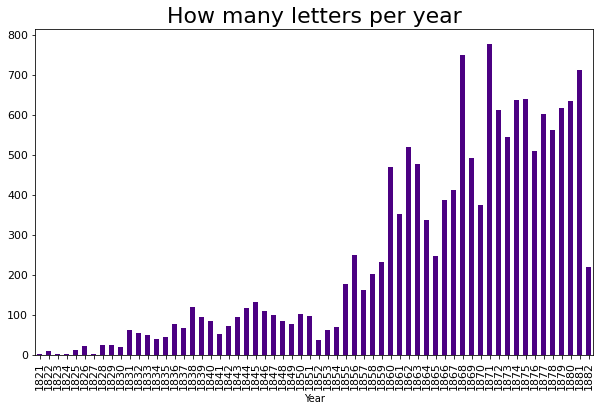

In [ ]:
ax = df0.plot(kind='bar', figsize=(10,6), color="indigo", fontsize=11);
#ax.set_alpha(0.5)
ax.set_title("How many letters per year", fontsize=22)
plt.show()

## 3. Linguistic pre-processing

From here you can **skip** to the code line "df = pd.read_csv(os.path.join(out_folder, 'transcription_tokens.csv'), sep = "\t")"

Add a space before and after every m-dash:

In [ ]:
s = "– – –Museum three — one from"
pat = re.compile(r"(\u2014)")
s = pat.sub(" \\1 ", s)
pat1 = re.compile(r"(\u2013)")
s = pat1.sub(" \\1 ", s)
s = s.replace("  ", " ")
s

' –  –  – Museum three — one from'

In [ ]:
s = "– – –Museum three — one from"
pat = re.compile(r"(\u2014)")
pat1 = re.compile(r"(\u2013)")
s = pat.sub(" \\1 ", pat1.sub(" \\1 ", s)).replace("  ", " ")
s

' –  –  – Museum three — one from'

In [ ]:
pat = re.compile(r"(\u2014)")
pat1 = re.compile(r"(\u2013)")
df['Transcription'] = [pat.sub(" \\1 ", pat1.sub(" \\1 ", df['Transcription'].iloc[i])).replace("  ", " ") for i in range(df.shape[0])]
df

,File,Year,Sender,Receiver,Transcription
0,DCP-LETT-13876.xml,1871,"Darwin, C. R.",Unidentified,"Charles Darwin My health keeps much as it was; I never escape for a whole day without much discomfort, of course as I grow older I become much weaker. —"
1,DCP-LETT-10515F.xml,1876,"Darwin, C. R.","Zincke, F. B.","I am very much obliged for your interesting letter. The case of the white chickens surprises me much, but nothing can be more perplexing than the ‘laws causes of variability inheritance. I am glad that any of my books should have at all interested you, as some return for the pleasure which I have derived from yours. I am writing this away from home, which I have left for some rest, so I beg you to excuse brevity. — Dear Sir | Yours faithfully | Ch. Darwin"
2,DCP-LETT-5961.xml,1868,"Darwin, C. R.","Bush, John","Mr Buckland has told me that you would excuse the liberty which I take in writing to you. — I am anxious for any information in regard to the proportional numbers of males females born to any animals; but this can hardly be told except with domestic or semi-domestic animals. — Mr. B. says that you have bred many rats, if you have kept any Memoranda, or have a decided impression on the relative numbers of the two sexes, I shd be grateful for information. — Perhaps you can also tell me whether male rats fight for the possession of the female, whether an old powerful rat is polygamous will keep several wifes. — Hoping that you will excuse my troubling you, I remain | Dear Sir | Yours very faithfully | Ch. Darwin My address for next 3 or 4 weeks will be 6. Queen Anne St Cavendish Sqe London W."
3,DCP-LETT-2753F.xml,1860,"Darwin, C. R.",Bookseller,"Please procure send me by Post, Mr Pat. Matthew’s work on “Naval Timber Arboriculture” 1831. Adam Black Edinburgh Longman London. — Dear Sir, | Yours faithfully | C. Darwin"
4,DCP-LETT-8607A.xml,1872,"Darwin, C. R.","Murray, John (b)","I have by this same post sent off the few trifling errata to Mr Clowes. — Have you given orders about the Heliotypes? I am very glad of your news. — Let me hear sale of all my books, — In Haste | C. Darwin"
...,...,...,...,...,...
14910,DCP-LETT-10624.xml,1876,"Darwin, C. R.","Marshall, W. C.","Mr. L. will meet you here on Tuesday. — You had better write direct to him, appointing hour, address him “Mr. Laslett Builder Farnborough Kent.” We leave home early on Wednesday morning therefore we cannot ask you to sleep here, as you seem so busy I daresay it wd be inconvenient for you to do so. Yours very sincerely | Ch. Darwin"
14911,DCP-LETT-10410.xml,1876,"Darwin, C. R.",Unidentified,I have the pleasure to send some autographs as you desire Yours very faithfully | Ch. Darwin Charles Darwin | Down Kent | Feb. 25th 1876 | Charles Darwin
14912,DCP-LETT-10604.xml,1876,"Darwin, C. R.","Darwin, Francis","I send by this post Chapt IX, but I earnestly beg you not to strain your mind return the sheets marked “uncorrected” if, as I expect, you find it too much for you. — It will give me only a little additional trouble. The figures have not been compared. As I had Chapt VIII almost finished a week ago, I despatched it then to the Printers: it had no figures related to the constitutional vigour of the crossed Plants. Some of the present sheets are so heavily corrected that they will be difficult for you to read. I have put your tools c up-stairs in order so far as not to be injured; but I cannot find your compound microscope to protect from dust. — I have made a few notes on the state of your plants in the Hot-house. My dearest son, your little note yesterday to mother, in which you say that you love me was the greatest possible comfort to me. I have been thinking much about you during your whole life, I am sure that you have deserved the love of your poor dear sweet darling. I am so deeply glad that she did not suffer at last, — it is my only poor consolation. God bless you my dearest son. Give my best love to Mrs. Ruck: I never in my life saw her equal for g

In [ ]:
df[df['File'] == "DCP-LETT-686.xml"]

,File,Year,Sender,Receiver,Transcription
4883,DCP-LETT-686.xml,1843,"Waterhouse, G. R.","Darwin, C. R.","– – – Museum three — one from Dr. Richardson who is well known there having worked much in the collection; one from Mr Yarrell one from Mr. Bowerbank — I will make it a point to borrow Whewell’s book from Owen to read it the moment he returns — As regards Classification of animals some conclusions I have come to are as follows — That species of animals belonging to the same genus may have an affinity to each other; genera of the same family may have a mutual affinity; relationship of affinity may likewise exist between orders of the same class, but the degree of affinity is different in the different cases — The affinity between species of the same genus may be called an affinity of the first degree; that of genera to genera, of the same family, of the second, or more remote, degree; and, that of families of the third degree so on — Then species of one family have affinity with species of other families of the same order an affinity of the third degree only, and species of different orders of the fourth degree only — That some such feeling as this is impressed upon Naturalists may be inferred from the pains that is taken to place prominently the points of resemblance between animals of different groups of high value — as in the case of the affinity of the ornithrhynchus, or the Echidna, to the Reptiles — the differences here I do not find are dwelt upon with the same ‘gout’ as the points of resemblance — The affinity of the Ornithorhynchus to the Echidna in very much closer than that of either of these animals to the Classes Reptilia, or Aves, — of a different nature as I will undertake to show — That other, and closer links between the Classes may hereafter be found would be stupid to deny, but as a matter of feeling — reasoning from analogies — I do not expect it. There is much to be said on this subject which I will trouble you with hereafter — I have been hard at work at brains for some time past immensely interested with my studies because in some respects I find the result so very different from what I expected. The Whales for instance are placed by Cuvier many Naturalists at the end of the Class Mammalia, yet they have a most highly organized brain — I have puzzled myself much about this matter, for although from all I can learn of the Whales they appear to enjoy a considerable stock of intelligence it does not at all come up to what would be inferred from the consideration of the brain alone — and, it has occurred to me that as the brain is a thing to be educated from without it does not follow that what would be termed a highly organized brain is necessarily followed by corresponding intelligence in the animal — The whales have many of them no olfactory nerves in the others they are in a most rudimentary condition — Their organ of vision does not appear to be particularly good — Of legs they have none their hands most unfitted for touch — and yet this animal has to suckle its young c — he ought to have a good brain to recompense him for the imperfections of the educatory media — Among the Carnivora, the brain of the seal is perhaps one of the highest this poor brute is likewise in a bad school — I mention this as having connexion with “The physiological importance to life of different structures” — I may add that in animals of the same group (in the Quadrumana for instance) there is immense difference in the structure of the brain — species of many groups have a much higher brain than the lowest Quadrumana but none have so good a brain as the highest of that order — as a general rule each group begins as it were lower than its predecessor (beginning at the bottom) terminates higher — each at the same time seems to perfect something — in the organs of respiration, circulation locomotion the bird is higher than Man — Having had my bit of chat I will go to bed — so good night | Always sincerely yours | Geo. R. Waterho

load the spaCy language model:

In [ ]:
sp = spacy.load("en_core_web_sm")

I split the letters into sentences, although this step may not be needed in the end. **NB** This can take about 10 minutes.

In [ ]:
#df['Transcription_sentences'] = [sp(df['Transcription'].iloc[i]) for i in range(df.shape[0])]
df['Transcription_spacy'] = [sp(df['Transcription'].iloc[i]) for i in range(df.shape[0])]
#df['Transcription_sentences'] = [ sentence for sentence in (df['Transcription'].iloc[i]).sents for i in range(df.shape[0])]
df

,File,Year,Sender,Receiver,Transcription,Transcription_spacy
0,DCP-LETT-13876.xml,1871,"Darwin, C. R.",Unidentified,"Charles Darwin My health keeps much as it was; I never escape for a whole day without much discomfort, of course as I grow older I become much weaker. —","(Charles, Darwin, My, health, keeps, much, as, it, was, ;, I, never, escape, for, a, whole, day, without, much, discomfort, ,, of, course, as, I, grow, older, I, become, much, weaker, ., —)"
1,DCP-LETT-10515F.xml,1876,"Darwin, C. R.","Zincke, F. B.","I am very much obliged for your interesting letter. The case of the white chickens surprises me much, but nothing can be more perplexing than the ‘laws causes of variability inheritance. I am glad that any of my books should have at all interested you, as some return for the pleasure which I have derived from yours. I am writing this away from home, which I have left for some rest, so I beg you to excuse brevity. — Dear Sir | Yours faithfully | Ch. Darwin","(I, am, very, much, obliged, for, your, interesting, letter, ., The, case, of, the, white, chickens, surprises, me, much, ,, but, nothing, can, be, more, perplexing, than, the, ‘, laws, causes, of, variability, inheritance, ., I, am, glad, that, any, of, my, books, should, have, at, all, interested, you, ,, as, some, return, for, the, pleasure, which, I, have, derived, from, yours, ., I, am, writing, this, away, from, home, ,, which, I, have, left, for, some, rest, ,, so, I, beg, you, to, excuse, brevity, ., —, Dear, Sir, |, Yours, faithfully, |, Ch, ., Darwin)"
2,DCP-LETT-5961.xml,1868,"Darwin, C. R.","Bush, John","Mr Buckland has told me that you would excuse the liberty which I take in writing to you. — I am anxious for any information in regard to the proportional numbers of males females born to any animals; but this can hardly be told except with domestic or semi-domestic animals. — Mr. B. says that you have bred many rats, if you have kept any Memoranda, or have a decided impression on the relative numbers of the two sexes, I shd be grateful for information. — Perhaps you can also tell me whether male rats fight for the possession of the female, whether an old powerful rat is polygamous will keep several wifes. — Hoping that you will excuse my troubling you, I remain | Dear Sir | Yours very faithfully | Ch. Darwin My address for next 3 or 4 weeks will be 6. Queen Anne St Cavendish Sqe London W.","(Mr, Buckland, has, told, me, that, you, would, excuse, the, liberty, which, I, take, in, writing, to, you, ., —, I, am, anxious, for, any, information, in, regard, to, the, proportional, numbers, of, males, females, born, to, any, animals, ;, but, this, can, hardly, be, told, except, with, domestic, or, semi, -, domestic, animals, ., —, Mr., B., , says, that, you, have, bred, many, rats, ,, if, you, have, kept, any, Memoranda, ,, or, have, a, decided, impression, on, the, relative, numbers, of, the, two, sexes, ,, I, shd, be, grateful, for, information, ., —, Perhaps, you, can, also, ...)"
3,DCP-LETT-2753F.xml,1860,"Darwin, C. R.",Bookseller,"Please procure send me by Post, Mr Pat. Matthew’s work on “Naval Timber Arboriculture” 1831. Adam Black Edinburgh Longman London. — Dear Sir, | Yours faithfully | C. Darwin","(Please, procure, send, me, by, Post, ,, Mr, Pat, ., Matthew, ’s, work, on, “, Naval, Timber, Arboriculture, ”, 1831, ., Adam, Black, Edinburgh, Longman, London, ., —, Dear, Sir, ,, |, Yours, faithfully, |, C., , Darwin)"
4,DCP-LETT-8607A.xml,1872,"Darwin, C. R.","Murray, John (b)","I have by this same post sent off the few trifling errata to Mr Clowes. — Have you given orders about the Heliotypes? I am very glad of your news. — Let me hear sale of all my books, — In Haste | C. Darwin","(I, have, by, this, same, post, sent, off, the, few, trifling, errata, to, Mr, Clowes, ., —, Have, you, given, orders, about, the, Heliotypes, ?, I, am, very, glad, of, your, news, ., —, Let, me, hear, sale, of, all, my, books, ,, —, In, Haste, |, C., , Darwin)"
...,..

A token simply refers to an individual part of a sentence having some semantic value. Let's see what tokens we have in our document. **NB This takes about 12 minutes**.

In [ ]:
df['Tokens'] = [[word.text for word in sp(df['Transcription'].iloc[i])] for i in range(df.shape[0])]
df

,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens
0,DCP-LETT-13876.xml,1871,"Darwin, C. R.",Unidentified,"Charles Darwin My health keeps much as it was; I never escape for a whole day without much discomfort, of course as I grow older I become much weaker. —","(Charles, Darwin, My, health, keeps, much, as, it, was, ;, I, never, escape, for, a, whole, day, without, much, discomfort, ,, of, course, as, I, grow, older, I, become, much, weaker, ., —)","[Charles, Darwin, My, health, keeps, much, as, it, was, ;, I, never, escape, for, a, whole, day, without, much, discomfort, ,, of, course, as, I, grow, older, I, become, much, weaker, ., —]"
1,DCP-LETT-10515F.xml,1876,"Darwin, C. R.","Zincke, F. B.","I am very much obliged for your interesting letter. The case of the white chickens surprises me much, but nothing can be more perplexing than the ‘laws causes of variability inheritance. I am glad that any of my books should have at all interested you, as some return for the pleasure which I have derived from yours. I am writing this away from home, which I have left for some rest, so I beg you to excuse brevity. — Dear Sir | Yours faithfully | Ch. Darwin","(I, am, very, much, obliged, for, your, interesting, letter, ., The, case, of, the, white, chickens, surprises, me, much, ,, but, nothing, can, be, more, perplexing, than, the, ‘, laws, causes, of, variability, inheritance, ., I, am, glad, that, any, of, my, books, should, have, at, all, interested, you, ,, as, some, return, for, the, pleasure, which, I, have, derived, from, yours, ., I, am, writing, this, away, from, home, ,, which, I, have, left, for, some, rest, ,, so, I, beg, you, to, excuse, brevity, ., —, Dear, Sir, |, Yours, faithfully, |, Ch, ., Darwin)","[I, am, very, much, obliged, for, your, interesting, letter, ., The, case, of, the, white, chickens, surprises, me, much, ,, but, nothing, can, be, more, perplexing, than, the, ‘, laws, causes, of, variability, inheritance, ., I, am, glad, that, any, of, my, books, should, have, at, all, interested, you, ,, as, some, return, for, the, pleasure, which, I, have, derived, from, yours, ., I, am, writing, this, away, from, home, ,, which, I, have, left, for, some, rest, ,, so, I, beg, you, to, excuse, brevity, ., —, Dear, Sir, |, Yours, faithfully, |, Ch, ., Darwin]"
2,DCP-LETT-5961.xml,1868,"Darwin, C. R.","Bush, John","Mr Buckland has told me that you would excuse the liberty which I take in writing to you. — I am anxious for any information in regard to the proportional numbers of males females born to any animals; but this can hardly be told except with domestic or semi-domestic animals. — Mr. B. says that you have bred many rats, if you have kept any Memoranda, or have a decided impression on the relative numbers of the two sexes, I shd be grateful for information. — Perhaps you can also tell me whether male rats fight for the possession of the female, whether an old powerful rat is polygamous will keep several wifes. — Hoping that you will excuse my troubling you, I remain | Dear Sir | Yours very faithfully | Ch. Darwin My address for next 3 or 4 weeks will be 6. Queen Anne St Cavendish Sqe London W.","(Mr, Buckland, has, told, me, that, you, would, excuse, the, liberty, which, I, take, in, writing, to, you, ., —, I, am, anxious, for, any, information, in, regard, to, the, proportional, numbers, of, males, females, born, to, any, animals, ;, but, this, can, hardly, be, told, except, with, domestic, or, semi, -, domestic, animals, ., —, Mr., B., , says, that, you, have, bred, many, rats, ,, if, you, have, kept, any, Memoranda, ,, or, have, a, decided, impression, on, the, relative, numbers, of, the, two, sexes, ,, I, shd, be, grateful, for, information, ., —, Perhaps, you, can, also, ...)","[Mr, Buckland, has, told, me, that, you, would, excuse, the, liberty, which, I, take, in, writing, to, you, ., —, I, am, anxious, for, any, information, in, regard, to, the, proportional, numbers, of, males, females, bor

In [ ]:
df[df['File'] == "DCP-LETT-686.xml"]

,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens
4883,DCP-LETT-686.xml,1843,"Waterhouse, G. R.","Darwin, C. R.","– – – Museum three — one from Dr. Richardson who is well known there having worked much in the collection; one from Mr Yarrell one from Mr. Bowerbank — I will make it a point to borrow Whewell’s book from Owen to read it the moment he returns — As regards Classification of animals some conclusions I have come to are as follows — That species of animals belonging to the same genus may have an affinity to each other; genera of the same family may have a mutual affinity; relationship of affinity may likewise exist between orders of the same class, but the degree of affinity is different in the different cases — The affinity between species of the same genus may be called an affinity of the first degree; that of genera to genera, of the same family, of the second, or more remote, degree; and, that of families of the third degree so on — Then species of one family have affinity with species of other families of the same order an affinity of the third degree only, and species of different orders of the fourth degree only — That some such feeling as this is impressed upon Naturalists may be inferred from the pains that is taken to place prominently the points of resemblance between animals of different groups of high value — as in the case of the affinity of the ornithrhynchus, or the Echidna, to the Reptiles — the differences here I do not find are dwelt upon with the same ‘gout’ as the points of resemblance — The affinity of the Ornithorhynchus to the Echidna in very much closer than that of either of these animals to the Classes Reptilia, or Aves, — of a different nature as I will undertake to show — That other, and closer links between the Classes may hereafter be found would be stupid to deny, but as a matter of feeling — reasoning from analogies — I do not expect it. There is much to be said on this subject which I will trouble you with hereafter — I have been hard at work at brains for some time past immensely interested with my studies because in some respects I find the result so very different from what I expected. The Whales for instance are placed by Cuvier many Naturalists at the end of the Class Mammalia, yet they have a most highly organized brain — I have puzzled myself much about this matter, for although from all I can learn of the Whales they appear to enjoy a considerable stock of intelligence it does not at all come up to what would be inferred from the consideration of the brain alone — and, it has occurred to me that as the brain is a thing to be educated from without it does not follow that what would be termed a highly organized brain is necessarily followed by corresponding intelligence in the animal — The whales have many of them no olfactory nerves in the others they are in a most rudimentary condition — Their organ of vision does not appear to be particularly good — Of legs they have none their hands most unfitted for touch — and yet this animal has to suckle its young c — he ought to have a good brain to recompense him for the imperfections of the educatory media — Among the Carnivora, the brain of the seal is perhaps one of the highest this poor brute is likewise in a bad school — I mention this as having connexion with “The physiological importance to life of different structures” — I may add that in animals of the same group (in the Quadrumana for instance) there is immense difference in the structure of the brain — species of many groups have a much higher brain than the lowest Quadrumana but none have so good a brain as the highest of that order — as a general rule each group begins as it were lower than its predecessor (beginning at the bottom) terminates higher — each at the same time seems to perfect something — in the organs of respiration, circulation locomotion the bird is higher than Man — Having had my bit of chat I will go to bed — so good night | Always sincer

### Lemmatisation

I lemmatise the letters. **NB this can take about 12 minutes.**

In [ ]:
df['Lemmas'] = [[word.lemma_ for word in sp(df['Transcription'].iloc[i])] for i in range(df.shape[0])]
df

,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens,Lemmas
0,DCP-LETT-13876.xml,1871,"Darwin, C. R.",Unidentified,"Charles Darwin My health keeps much as it was; I never escape for a whole day without much discomfort, of course as I grow older I become much weaker. —","(Charles, Darwin, My, health, keeps, much, as, it, was, ;, I, never, escape, for, a, whole, day, without, much, discomfort, ,, of, course, as, I, grow, older, I, become, much, weaker, ., —)","[Charles, Darwin, My, health, keeps, much, as, it, was, ;, I, never, escape, for, a, whole, day, without, much, discomfort, ,, of, course, as, I, grow, older, I, become, much, weaker, ., —]","[Charles, Darwin, -PRON-, health, keep, much, as, -PRON-, be, ;, -PRON-, never, escape, for, a, whole, day, without, much, discomfort, ,, of, course, as, -PRON-, grow, old, -PRON-, become, much, weak, ., —]"
1,DCP-LETT-10515F.xml,1876,"Darwin, C. R.","Zincke, F. B.","I am very much obliged for your interesting letter. The case of the white chickens surprises me much, but nothing can be more perplexing than the ‘laws causes of variability inheritance. I am glad that any of my books should have at all interested you, as some return for the pleasure which I have derived from yours. I am writing this away from home, which I have left for some rest, so I beg you to excuse brevity. — Dear Sir | Yours faithfully | Ch. Darwin","(I, am, very, much, obliged, for, your, interesting, letter, ., The, case, of, the, white, chickens, surprises, me, much, ,, but, nothing, can, be, more, perplexing, than, the, ‘, laws, causes, of, variability, inheritance, ., I, am, glad, that, any, of, my, books, should, have, at, all, interested, you, ,, as, some, return, for, the, pleasure, which, I, have, derived, from, yours, ., I, am, writing, this, away, from, home, ,, which, I, have, left, for, some, rest, ,, so, I, beg, you, to, excuse, brevity, ., —, Dear, Sir, |, Yours, faithfully, |, Ch, ., Darwin)","[I, am, very, much, obliged, for, your, interesting, letter, ., The, case, of, the, white, chickens, surprises, me, much, ,, but, nothing, can, be, more, perplexing, than, the, ‘, laws, causes, of, variability, inheritance, ., I, am, glad, that, any, of, my, books, should, have, at, all, interested, you, ,, as, some, return, for, the, pleasure, which, I, have, derived, from, yours, ., I, am, writing, this, away, from, home, ,, which, I, have, left, for, some, rest, ,, so, I, beg, you, to, excuse, brevity, ., —, Dear, Sir, |, Yours, faithfully, |, Ch, ., Darwin]","[-PRON-, be, very, much, oblige, for, -PRON-, interesting, letter, ., the, case, of, the, white, chicken, surprise, -PRON-, much, ,, but, nothing, can, be, more, perplexing, than, the, ', law, cause, of, variability, inheritance, ., -PRON-, be, glad, that, any, of, -PRON-, book, should, have, at, all, interest, -PRON-, ,, as, some, return, for, the, pleasure, which, -PRON-, have, derive, from, your, ., -PRON-, be, write, this, away, from, home, ,, which, -PRON-, have, leave, for, some, rest, ,, so, -PRON-, beg, -PRON-, to, excuse, brevity, ., —, Dear, Sir, |, Yours, faithfully, |, Ch, ., Darwin]"
2,DCP-LETT-5961.xml,1868,"Darwin, C. R.","Bush, John","Mr Buckland has told me that you would excuse the liberty which I take in writing to you. — I am anxious for any information in regard to the proportional numbers of males females born to any animals; but this can hardly be told except with domestic or semi-domestic animals. — Mr. B. says that you have bred many rats, if you have kept any Memoranda, or have a decided impression on the relative numbers of the two sexes, I shd be grateful for information. — Perhaps you can also tell me whether male rats fight for the possession of the female, whether an old powerful rat is polygamous will keep several wifes. — Hoping that you will excuse my troubling you, I remain | Dear Sir | Yours very faithfully | Ch. Darwin My address for next 3 or 4 weeks will be 6. Queen Anne St Cavendish Sqe London W."

#### Stopwords exclusion and further filtering
I exclude non-alphabetical characters:

In [ ]:
df["Lemmas_clean"] = ''
for i in range(df.shape[0]):
  df['Lemmas_clean'].iloc[i] = [t for t in df['Lemmas'].iloc[i] if t not in '''!()-[]{};:\'"\,<>./?@#$%^&*_~\|–—\“’`''']# and t.isalpha() ]
df

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens,Lemmas,Lemmas_clean
0,DCP-LETT-13876.xml,1871,"Darwin, C. R.",Unidentified,"Charles Darwin My health keeps much as it was; I never escape for a whole day without much discomfort, of course as I grow older I become much weaker. —","(Charles, Darwin, My, health, keeps, much, as, it, was, ;, I, never, escape, for, a, whole, day, without, much, discomfort, ,, of, course, as, I, grow, older, I, become, much, weaker, ., —)","[Charles, Darwin, My, health, keeps, much, as, it, was, ;, I, never, escape, for, a, whole, day, without, much, discomfort, ,, of, course, as, I, grow, older, I, become, much, weaker, ., —]","[Charles, Darwin, -PRON-, health, keep, much, as, -PRON-, be, ;, -PRON-, never, escape, for, a, whole, day, without, much, discomfort, ,, of, course, as, -PRON-, grow, old, -PRON-, become, much, weak, ., —]","[Charles, Darwin, -PRON-, health, keep, much, as, -PRON-, be, -PRON-, never, escape, for, a, whole, day, without, much, discomfort, of, course, as, -PRON-, grow, old, -PRON-, become, much, weak]"
1,DCP-LETT-10515F.xml,1876,"Darwin, C. R.","Zincke, F. B.","I am very much obliged for your interesting letter. The case of the white chickens surprises me much, but nothing can be more perplexing than the ‘laws causes of variability inheritance. I am glad that any of my books should have at all interested you, as some return for the pleasure which I have derived from yours. I am writing this away from home, which I have left for some rest, so I beg you to excuse brevity. — Dear Sir | Yours faithfully | Ch. Darwin","(I, am, very, much, obliged, for, your, interesting, letter, ., The, case, of, the, white, chickens, surprises, me, much, ,, but, nothing, can, be, more, perplexing, than, the, ‘, laws, causes, of, variability, inheritance, ., I, am, glad, that, any, of, my, books, should, have, at, all, interested, you, ,, as, some, return, for, the, pleasure, which, I, have, derived, from, yours, ., I, am, writing, this, away, from, home, ,, which, I, have, left, for, some, rest, ,, so, I, beg, you, to, excuse, brevity, ., —, Dear, Sir, |, Yours, faithfully, |, Ch, ., Darwin)","[I, am, very, much, obliged, for, your, interesting, letter, ., The, case, of, the, white, chickens, surprises, me, much, ,, but, nothing, can, be, more, perplexing, than, the, ‘, laws, causes, of, variability, inheritance, ., I, am, glad, that, any, of, my, books, should, have, at, all, interested, you, ,, as, some, return, for, the, pleasure, which, I, have, derived, from, yours, ., I, am, writing, this, away, from, home, ,, which, I, have, left, for, some, rest, ,, so, I, beg, you, to, excuse, brevity, ., —, Dear, Sir, |, Yours, faithfully, |, Ch, ., Darwin]","[-PRON-, be, very, much, oblige, for, -PRON-, interesting, letter, ., the, case, of, the, white, chicken, surprise, -PRON-, much, ,, but, nothing, can, be, more, perplexing, than, the, ', law, cause, of, variability, inheritance, ., -PRON-, be, glad, that, any, of, -PRON-, book, should, have, at, all, interest, -PRON-, ,, as, some, return, for, the, pleasure, which, -PRON-, have, derive, from, your, ., -PRON-, be, write, this, away, from, home, ,, which, -PRON-, have, leave, for, some, rest, ,, so, -PRON-, beg, -PRON-, to, excuse, brevity, ., —, Dear, Sir, |, Yours, faithfully, |, Ch, ., Darwin]","[-PRON-, be, very, much, oblige, for, -PRON-, interesting, letter, the, case, of, the, white, chicken, surprise, -PRON-, much, but, nothing, can, be, more, perplexing, than, the, law, cause, of, variability, inheritance, -PRON-, be, glad, that, any, of, -PRON-, book, should, have, at, all, interest, -PRON-, as, some, return, for, the, pleasure, which, -PRON-, have, derive, from, your, -PRON-, be, write, this, away, from, home, which, -PRON-, have, leave, for, some, rest, so, -PRON-, beg, -PRON-, to, excuse, brevity, Dear, Sir, Yours, faithfully, Ch, Darwin]"
2,DCP-LETT-5961.xml,1868,"Darwin, C. R.","Bush, John","Mr Buckland has told me t

I exclude stop words, although they will be needed for word embedding training:

In [ ]:
stopWords = set(stopwords.words('english'))
df["Lemmas_nostop"] = ''
for i in range(df.shape[0]):
  df['Lemmas_nostop'].iloc[i] = [t for t in df['Lemmas'].iloc[i] if t not in stopWords]
df

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens,Lemmas,Lemmas_clean,Lemmas_nostop
0,DCP-LETT-13876.xml,1871,"Darwin, C. R.",Unidentified,"Charles Darwin My health keeps much as it was; I never escape for a whole day without much discomfort, of course as I grow older I become much weaker. —","(Charles, Darwin, My, health, keeps, much, as, it, was, ;, I, never, escape, for, a, whole, day, without, much, discomfort, ,, of, course, as, I, grow, older, I, become, much, weaker, ., —)","[Charles, Darwin, My, health, keeps, much, as, it, was, ;, I, never, escape, for, a, whole, day, without, much, discomfort, ,, of, course, as, I, grow, older, I, become, much, weaker, ., —]","[Charles, Darwin, -PRON-, health, keep, much, as, -PRON-, be, ;, -PRON-, never, escape, for, a, whole, day, without, much, discomfort, ,, of, course, as, -PRON-, grow, old, -PRON-, become, much, weak, ., —]","[Charles, Darwin, -PRON-, health, keep, much, as, -PRON-, be, -PRON-, never, escape, for, a, whole, day, without, much, discomfort, of, course, as, -PRON-, grow, old, -PRON-, become, much, weak]","[Charles, Darwin, -PRON-, health, keep, much, -PRON-, ;, -PRON-, never, escape, whole, day, without, much, discomfort, ,, course, -PRON-, grow, old, -PRON-, become, much, weak, ., —]"
1,DCP-LETT-10515F.xml,1876,"Darwin, C. R.","Zincke, F. B.","I am very much obliged for your interesting letter. The case of the white chickens surprises me much, but nothing can be more perplexing than the ‘laws causes of variability inheritance. I am glad that any of my books should have at all interested you, as some return for the pleasure which I have derived from yours. I am writing this away from home, which I have left for some rest, so I beg you to excuse brevity. — Dear Sir | Yours faithfully | Ch. Darwin","(I, am, very, much, obliged, for, your, interesting, letter, ., The, case, of, the, white, chickens, surprises, me, much, ,, but, nothing, can, be, more, perplexing, than, the, ‘, laws, causes, of, variability, inheritance, ., I, am, glad, that, any, of, my, books, should, have, at, all, interested, you, ,, as, some, return, for, the, pleasure, which, I, have, derived, from, yours, ., I, am, writing, this, away, from, home, ,, which, I, have, left, for, some, rest, ,, so, I, beg, you, to, excuse, brevity, ., —, Dear, Sir, |, Yours, faithfully, |, Ch, ., Darwin)","[I, am, very, much, obliged, for, your, interesting, letter, ., The, case, of, the, white, chickens, surprises, me, much, ,, but, nothing, can, be, more, perplexing, than, the, ‘, laws, causes, of, variability, inheritance, ., I, am, glad, that, any, of, my, books, should, have, at, all, interested, you, ,, as, some, return, for, the, pleasure, which, I, have, derived, from, yours, ., I, am, writing, this, away, from, home, ,, which, I, have, left, for, some, rest, ,, so, I, beg, you, to, excuse, brevity, ., —, Dear, Sir, |, Yours, faithfully, |, Ch, ., Darwin]","[-PRON-, be, very, much, oblige, for, -PRON-, interesting, letter, ., the, case, of, the, white, chicken, surprise, -PRON-, much, ,, but, nothing, can, be, more, perplexing, than, the, ', law, cause, of, variability, inheritance, ., -PRON-, be, glad, that, any, of, -PRON-, book, should, have, at, all, interest, -PRON-, ,, as, some, return, for, the, pleasure, which, -PRON-, have, derive, from, your, ., -PRON-, be, write, this, away, from, home, ,, which, -PRON-, have, leave, for, some, rest, ,, so, -PRON-, beg, -PRON-, to, excuse, brevity, ., —, Dear, Sir, |, Yours, faithfully, |, Ch, ., Darwin]","[-PRON-, be, very, much, oblige, for, -PRON-, interesting, letter, the, case, of, the, white, chicken, surprise, -PRON-, much, but, nothing, can, be, more, perplexing, than, the, law, cause, of, variability, inheritance, -PRON-, be, glad, that, any, of, -PRON-, book, should, have, at, all, interest, -PRON-, as, some, return, for, the, pleasure, which, -PRON-, have, derive, from, your, -PRON-, be, write, this, away, from, home, which, -PRON-, 

I add the language of the letters in an additional column. **NB This takes 2 minutes.**

In [ ]:
transcriptions = df[['Transcription']].to_numpy().flatten().tolist()
df[['language']] = [detect(x) for x in transcriptions]

In [ ]:
df

,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens,Lemmas,Lemmas_clean,Lemmas_nostop,language
0,DCP-LETT-13876.xml,1871,"Darwin, C. R.",Unidentified,Charles Darwin My health keeps much as it was;...,"(Charles, Darwin, My, health, keeps, much, as,...","[Charles, Darwin, My, health, keeps, much, as,...","[Charles, Darwin, -PRON-, health, keep, much, ...","[Charles, Darwin, -PRON-, health, keep, much, ...","[Charles, Darwin, -PRON-, health, keep, much, ...",en
1,DCP-LETT-10515F.xml,1876,"Darwin, C. R.","Zincke, F. B.",I am very much obliged for your interesting le...,"(I, am, very, much, obliged, for, your, intere...","[I, am, very, much, obliged, for, your, intere...","[-PRON-, be, very, much, oblige, for, -PRON-, ...","[-PRON-, be, very, much, oblige, for, -PRON-, ...","[-PRON-, much, oblige, -PRON-, interesting, le...",en
2,DCP-LETT-5961.xml,1868,"Darwin, C. R.","Bush, John",Mr Buckland has told me that you would excuse ...,"(Mr, Buckland, has, told, me, that, you, would...","[Mr, Buckland, has, told, me, that, you, would...","[Mr, Buckland, have, tell, -PRON-, that, -PRON...","[Mr, Buckland, have, tell, -PRON-, that, -PRON...","[Mr, Buckland, tell, -PRON-, -PRON-, would, ex...",en
3,DCP-LETT-2753F.xml,1860,"Darwin, C. R.",Bookseller,"Please procure send me by Post, Mr Pat. Matthe...","(Please, procure, send, me, by, Post, ,, Mr, P...","[Please, procure, send, me, by, Post, ,, Mr, P...","[please, procure, send, -PRON-, by, Post, ,, M...","[please, procure, send, -PRON-, by, Post, Mr, ...","[please, procure, send, -PRON-, Post, ,, Mr, P...",en
4,DCP-LETT-8607A.xml,1872,"Darwin, C. R.","Murray, John (b)",I have by this same post sent off the few trif...,"(I, have, by, this, same, post, sent, off, the...","[I, have, by, this, same, post, sent, off, the...","[-PRON-, have, by, this, same, post, send, off...","[-PRON-, have, by, this, same, post, send, off...","[-PRON-, post, send, trifling, erratum, Mr, Cl...",en
...,...,...,...,...,...,...,...,...,...,...,...
14910,DCP-LETT-10624.xml,1876,"Darwin, C. R.","Marshall, W. C.",Mr. L. will meet you here on Tuesday. — You ha...,"(Mr., L., , will, meet, you, here, on, Tuesda...","[Mr., L., , will, meet, you, here, on, Tuesda...","[Mr., L., , will, meet, -PRON-, here, on, Tu...","[Mr., L., , will, meet, -PRON-, here, on, Tu...","[Mr., L., , meet, -PRON-, Tuesday, ., —, -PR...",en
14911,DCP-LETT-10410.xml,1876,"Darwin, C. R.",Unidentified,I have the pleasure to send some autographs as...,"(I, have, the, pleasure, to, send, some, autog...","[I, have, the, pleasure, to, send, some, autog...","[-PRON-, have, the, pleasure, to, send, some, ...","[-PRON-, have, the, pleasure, to, send, some, ...","[-PRON-, pleasure, send, autograph, -PRON-, de...",en
14912,DCP-LETT-10604.xml,1876,"Darwin, C. R.","Darwin, Francis","I send by this post Chapt IX, but I earnestly ...","(I, send, by, this, post, Chapt, IX, ,, but, I...","[I, send, by, this, post, Chapt, IX, ,, but, I...","[-PRON-, send, by, this, post, Chapt, IX, ,, b...","[-PRON-, send, by, this, post, Chapt, IX, but,...","[-PRON-, send, post, Chapt, IX, ,, -PRON-, ear...",en
14913,DCP-LETT-12856.xml,1880,"Pfeffer, W. F. P.","Darwin, C. R.",Although I have so far been able merely to lea...,"(Although, I, have, so, far, been, able, merel...","[Although, I, have, so, far, been, able, merel...","[although, -PRON-, have, so, far, be, able, me...","[although, -PRON-, have, so, far, be, able, me...","[although, -PRON-, far, able, merely, leaf, -P...",en


How many letters per language?

In [ ]:
df[['language']].value_counts()

language
en          14860
de             28
fr             11
ca              4
pt              2
no              2
vi              1
nl              1
it              1
id              1
hu              1
et              1
es              1
af              1
dtype: int64

Only keep letters in English:

In [ ]:
#df = df[~df.language.isin(['de', 'fr'])]
df = df[df.language.isin(['en'])]
df.shape

(14860, 11)

We only select the letters written by Charles Darwin:

In [ ]:
df1 = df[df['Sender'] == "Darwin, C. R."]
df1.shape

(8148, 11)

I save the dataframe to a file:

In [ ]:
df.to_csv(os.path.join(out_folder, 'transcription_tokens.csv'), encoding='utf-8', index = False, sep = "\t", quoting=csv.QUOTE_NONE)
df1.to_csv(os.path.join(out_folder, 'transcription_tokens_onlyDarwin.csv'), encoding='utf-8', index = False, sep = "\t", quoting=csv.QUOTE_NONE)

## 4. Training word embeddings

I read the dataframe from file:

In [ ]:
df1 = pd.read_csv(os.path.join(out_folder, 'transcription_tokens_onlyDarwin.csv'), sep = "\t")
df1

,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens,Lemmas,Lemmas_clean,Lemmas_nostop,language
0,DCP-LETT-13876.xml,1871,"Darwin, C. R.",Unidentified,"Charles Darwin My health keeps much as it was; I never escape for a whole day without much discomfort, of course as I grow older I become much weaker. —","Charles Darwin My health keeps much as it was; I never escape for a whole day without much discomfort, of course as I grow older I become much weaker. —","['Charles', 'Darwin', 'My', 'health', 'keeps', 'much', 'as', 'it', 'was', ';', 'I', 'never', 'escape', 'for', 'a', 'whole', 'day', 'without', 'much', 'discomfort', ',', 'of', 'course', 'as', 'I', 'grow', 'older', 'I', 'become', 'much', 'weaker', '.', '—']","['Charles', 'Darwin', '-PRON-', 'health', 'keep', 'much', 'as', '-PRON-', 'be', ';', '-PRON-', 'never', 'escape', 'for', 'a', 'whole', 'day', 'without', 'much', 'discomfort', ',', 'of', 'course', 'as', '-PRON-', 'grow', 'old', '-PRON-', 'become', 'much', 'weak', '.', '—']","['Charles', 'Darwin', '-PRON-', 'health', 'keep', 'much', 'as', '-PRON-', 'be', '-PRON-', 'never', 'escape', 'for', 'a', 'whole', 'day', 'without', 'much', 'discomfort', 'of', 'course', 'as', '-PRON-', 'grow', 'old', '-PRON-', 'become', 'much', 'weak']","['Charles', 'Darwin', '-PRON-', 'health', 'keep', 'much', '-PRON-', ';', '-PRON-', 'never', 'escape', 'whole', 'day', 'without', 'much', 'discomfort', ',', 'course', '-PRON-', 'grow', 'old', '-PRON-', 'become', 'much', 'weak', '.', '—']",en
1,DCP-LETT-10515F.xml,1876,"Darwin, C. R.","Zincke, F. B.","I am very much obliged for your interesting letter. The case of the white chickens surprises me much, but nothing can be more perplexing than the ‘laws causes of variability inheritance. I am glad that any of my books should have at all interested you, as some return for the pleasure which I have derived from yours. I am writing this away from home, which I have left for some rest, so I beg you to excuse brevity. — Dear Sir | Yours faithfully | Ch. Darwin","I am very much obliged for your interesting letter. The case of the white chickens surprises me much, but nothing can be more perplexing than the ‘laws causes of variability inheritance. I am glad that any of my books should have at all interested you, as some return for the pleasure which I have derived from yours. I am writing this away from home, which I have left for some rest, so I beg you to excuse brevity. — Dear Sir | Yours faithfully | Ch. Darwin","['I', 'am', 'very', 'much', 'obliged', 'for', 'your', 'interesting', 'letter', '.', 'The', 'case', 'of', 'the', 'white', 'chickens', 'surprises', 'me', 'much', ',', 'but', 'nothing', 'can', 'be', 'more', 'perplexing', 'than', 'the', '‘', 'laws', 'causes', 'of', 'variability', 'inheritance', '.', 'I', 'am', 'glad', 'that', 'any', 'of', 'my', 'books', 'should', 'have', 'at', 'all', 'interested', 'you', ',', 'as', 'some', 'return', 'for', 'the', 'pleasure', 'which', 'I', 'have', 'derived', 'from', 'yours', '.', 'I', 'am', 'writing', 'this', 'away', 'from', 'home', ',', 'which', 'I', 'have', 'left', 'for', 'some', 'rest', ',', 'so', 'I', 'beg', 'you', 'to', 'excuse', 'brevity', '.', '—', 'Dear', 'Sir', '|', 'Yours', 'faithfully', '|', 'Ch', '.', 'Darwin']","['-PRON-', 'be', 'very', 'much', 'oblige', 'for', '-PRON-', 'interesting', 'letter', '.', 'the', 'case', 'of', 'the', 'white', 'chicken', 'surprise', '-PRON-', 'much', ',', 'but', 'nothing', 'can', 'be', 'more', 'perplexing', 'than', 'the', ""'"", 'law', 'cause', 'of', 'variability', 'inheritance', '.', '-PRON-', 'be', 'glad', 'that', 'any', 'of', '-PRON-', 'book', 'should', 'have', 'at', 'all', 'interest', '-PRON-', ',', 'as', 'some', 'return', 'for', 'the', 'pleasure', 'which', '-PRON-', 'have', 'derive', 'from', 'your', '.', '-PRON-', 'be', 'write', 'this', 'away', 'from', 'home', ',', 'which', '-PRON-', 'have', 'leave', 'for', 'some', 'rest', ',', 'so', '-PRON-', 'beg', '-PRON-', 'to', 'excuse', 'brevity', '.', '—', 'Dear', 'Sir', '

Function for printing the vocabulary of a model

In [ ]:
def print_vocab(model, top_n = None):
  count = 0
  if top_n is not None:
    for index, word in enumerate(model.wv.index_to_key):
      count+= 1
      if count < top_n:
        print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
  else:
    for index, word in enumerate(model.wv.index_to_key):
      print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

In [ ]:
pd.set_option('display.max_colwidth', -1)
(df1['Lemmas_clean'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


0       ['Charles', 'Darwin', '-PRON-', 'health', 'keep', 'much', 'as', '-PRON-', 'be', '-PRON-', 'never', 'escape', 'for', 'a', 'whole', 'day', 'without', 'much', 'discomfort', 'of', 'course', 'as', '-PRON-', 'grow', 'old', '-PRON-', 'become', 'much', 'weak']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

I train Word2Vec embeddings from the letters. **You can skip this cell.**

`min_count`: the minimum frequency threshold allowed for a word to be included

`vector_size`: the number of dimensions in which we wish to represent our word. This is the size of the word embedding; typically between 100 and 1,000.

`window`: The size of the context window determines how many words before and after a given word would be included as context words of the given word.  Typically between 5 and 10.

`sg`: – Training algorithm: 1 for skip-gram; otherwise CBOW.


In [ ]:
start = time.time()
cbow_w5_f1_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=300, window = 5, sg = 0)
end = time.time()
print("It has taken", round(end - start), "seconds")
start = time.time()
cbow_w5_f1_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=1000, window = 5, sg = 0)
end = time.time()
print("It has taken", round(end - start), "seconds")

It has taken 43 seconds
It has taken 70 seconds


In [ ]:
print_vocab(cbow_w5_f1_300, 10)

word #0/142 is '
word #1/142 is  
word #2/142 is ,
word #3/142 is e
word #4/142 is t
word #5/142 is o
word #6/142 is a
word #7/142 is r
word #8/142 is n


Different parameters. **You can skip this cell.**

In [ ]:
#300 dimensions:
start = time.time()
cbow_w5_f0_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=300, window = 5, sg = 0)
end = time.time()
print("cbow_w5_f0_300 has taken", round(end - start), "seconds")
start = time.time()
sg_w5_f1_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=300, window = 5, sg = 1)
end = time.time()
print("sg_w5_f1_300 has taken", round(end - start), "seconds")
start = time.time()
sg_w5_f0_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=300, window = 5, sg = 1)
end = time.time()
print("sg_w5_f0_300 has taken", round(end - start), "seconds")
start = time.time()
cbow_w10_f1_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=300, window = 10, sg = 0)
end = time.time()
print("cbow_w10_f1_300 has taken", round(end - start), "seconds")
start = time.time()
cbow_w10_f0_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=300, window = 10, sg = 0)
end = time.time()
print("cbow_w10_f0_300 has taken", round(end - start), "seconds")
start = time.time()
sg_w10_f1_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=300, window = 10, sg = 1)
end = time.time()
print("sg_w10_f1_300 has taken", round(end - start), "seconds")
start = time.time()
sg_w10_f0_300 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=300, window = 10, sg = 1)
end = time.time()
print("sg_w10_f0_300 has taken", round(end - start), "seconds")
#1000 dimensions:
start = time.time()
cbow_w5_f0_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=1000, window = 5, sg = 0)
end = time.time()
print("cbow_w5_f0_1000 has taken", round(end - start), "seconds")
start = time.time()
sg_w5_f1_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=1000, window = 5, sg = 1)
end = time.time()
print("sg_w5_f1_1000 has taken", round(end - start), "seconds")
start = time.time()
sg_w5_f0_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=1000, window = 5, sg = 1)
end = time.time()
print("sg_w5_f0_1000 has taken", round(end - start), "seconds")
start = time.time()
cbow_w10_f1_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=1000, window = 10, sg = 0)
end = time.time()
print("cbow_w10_f1_1000 has taken", round(end - start), "seconds")
start = time.time()
cbow_w10_f0_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=1000, window = 10, sg = 0)
end = time.time()
print("cbow_w10_f0_1000 has taken", round(end - start), "seconds")
start = time.time()
sg_w10_f1_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=1000, window = 10, sg = 1)
end = time.time()
print("sg_w10_f1_1000 has taken", round(end - start), "seconds")
start = time.time()
sg_w10_f0_1000 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=0, vector_size=1000, window = 10, sg = 1)
end = time.time()
print("sg_w10_f0_1000 has taken", round(end - start), "seconds")

cbow_w5_f0_300 has taken 17 seconds
sg_w5_f1_300 has taken 54 seconds
sg_w5_f0_300 has taken 53 seconds
cbow_w10_f1_300 has taken 19 seconds
cbow_w10_f0_300 has taken 19 seconds
sg_w10_f1_300 has taken 93 seconds
sg_w10_f0_300 has taken 94 seconds
cbow_w5_f0_1000 has taken 31 seconds
sg_w5_f1_1000 has taken 107 seconds
sg_w5_f0_1000 has taken 107 seconds
cbow_w10_f1_1000 has taken 37 seconds
cbow_w10_f0_1000 has taken 37 seconds
sg_w10_f1_1000 has taken 190 seconds
sg_w10_f0_1000 has taken 191 seconds


Skip-gram is more computationally expensive, especially with larger window sizes.

Let's save the models so we can use them later. **You can skip this cell.**

In [ ]:
models_folder = '/content/drive/My Drive/2021/Darwin paper/Files/Models'
models = [cbow_w5_f1_300, cbow_w5_f1_1000, cbow_w5_f0_300, cbow_w5_f0_1000, sg_w5_f1_300, sg_w5_f1_1000, sg_w5_f0_300, sg_w5_f0_1000, cbow_w10_f1_300, cbow_w10_f1_1000, cbow_w10_f0_300, cbow_w10_f0_1000, sg_w10_f1_300, sg_w10_f1_1000, sg_w10_f0_300, sg_w10_f0_1000]
models_names = ['cbow_w5_f1_300', 'cbow_w5_f1_1000', 'cbow_w5_f0_300', 'cbow_w5_f0_1000', 'sg_w5_f1_300', 'sg_w5_f1_1000', 'sg_w5_f0_300', 'sg_w5_f0_1000', 'cbow_w10_f1_300', 'cbow_w10_f1_1000', 'cbow_w10_f0_300', 'cbow_w10_f0_1000', 'sg_w10_f1_300', 'sg_w10_f1_1000', 'sg_w10_f0_300', 'sg_w10_f0_1000']
for i in range(len(models)):
  print("Saving model number", i+1)
  models[i].save(os.path.join(models_folder, models_names[i]))

Saving model number 1
Saving model number 2
Saving model number 3
Saving model number 4
Saving model number 5
Saving model number 6
Saving model number 7
Saving model number 8
Saving model number 9
Saving model number 10
Saving model number 11
Saving model number 12
Saving model number 13
Saving model number 14
Saving model number 15
Saving model number 16


Load the models:

In [ ]:
models_folder = '/content/drive/My Drive/2021/Darwin paper/Files/Models'
cbow_w5_f1_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w5_f1_300"))
cbow_w5_f0_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w5_f0_300"))
sg_w5_f1_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w5_f1_300"))
sg_w5_f0_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w5_f0_300"))
cbow_w10_f1_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w10_f1_300"))
cbow_w10_f0_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w10_f0_300"))
sg_w10_f1_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w10_f1_300"))
sg_w10_f0_300 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w10_f0_300"))
cbow_w5_f1_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w5_f1_1000"))
cbow_w5_f0_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w5_f0_1000"))
sg_w5_f1_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w5_f1_1000"))
sg_w5_f0_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w5_f0_1000"))
cbow_w10_f1_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w10_f1_1000"))
cbow_w10_f0_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w10_f0_1000"))
sg_w10_f1_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w10_f1_1000"))
sg_w10_f0_1000 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w10_f0_1000"))
models = [cbow_w5_f1_300, cbow_w5_f1_1000, cbow_w5_f0_300, cbow_w5_f0_1000, sg_w5_f1_300, sg_w5_f1_1000, sg_w5_f0_300, sg_w5_f0_1000, cbow_w10_f1_300, cbow_w10_f1_1000, cbow_w10_f0_300, cbow_w10_f0_1000, sg_w10_f1_300, sg_w10_f1_1000, sg_w10_f0_300, sg_w10_f0_1000]
models_names = ['cbow_w5_f1_300', 'cbow_w5_f1_1000', 'cbow_w5_f0_300', 'cbow_w5_f0_1000', 'sg_w5_f1_300', 'sg_w5_f1_1000', 'sg_w5_f0_300', 'sg_w5_f0_1000', 'cbow_w10_f1_300', 'cbow_w10_f1_1000', 'cbow_w10_f0_300', 'cbow_w10_f0_1000', 'sg_w10_f1_300', 'sg_w10_f1_1000', 'sg_w10_f0_300', 'sg_w10_f0_1000']


Print the first ten words of the vocabulary of each model

In [ ]:
for i in range(len(models)):
  print(models_names[i])
  print_vocab(models[i], 10)

cbow_w5_f1_300
word #0/33047 is -PRON-
word #1/33047 is the
word #2/33047 is be
word #3/33047 is to
word #4/33047 is of
word #5/33047 is have
word #6/33047 is in
word #7/33047 is a
word #8/33047 is that
cbow_w5_f1_1000
word #0/33047 is -PRON-
word #1/33047 is the
word #2/33047 is be
word #3/33047 is to
word #4/33047 is of
word #5/33047 is have
word #6/33047 is in
word #7/33047 is a
word #8/33047 is that
cbow_w5_f0_300
word #0/33047 is -PRON-
word #1/33047 is the
word #2/33047 is be
word #3/33047 is to
word #4/33047 is of
word #5/33047 is have
word #6/33047 is in
word #7/33047 is a
word #8/33047 is that
cbow_w5_f0_1000
word #0/33047 is -PRON-
word #1/33047 is the
word #2/33047 is be
word #3/33047 is to
word #4/33047 is of
word #5/33047 is have
word #6/33047 is in
word #7/33047 is a
word #8/33047 is that
sg_w5_f1_300
word #0/33047 is -PRON-
word #1/33047 is the
word #2/33047 is be
word #3/33047 is to
word #4/33047 is of
word #5/33047 is have
word #6/33047 is in
word #7/33047 is a
word #8

Let's look at the most similar words (i.e. neighbours) of *letter*:

In [ ]:
for i in range(len(models)):
  print(models_names[i], models[i].wv.similar_by_word('letter', 10))

cbow_w5_f1_300 [('note', 0.919885516166687), ('pamphlet', 0.652788519859314), ('article', 0.6503540277481079), ('lecture', 0.5711215734481812), ('essay', 0.5618703961372375), ('delay', 0.5527163743972778), ('query', 0.5468353629112244), ('morning', 0.5438441038131714), ('sentence', 0.5436720252037048), ('Review', 0.5423902273178101)]
cbow_w5_f1_1000 [('note', 0.9176384806632996), ('article', 0.6700360774993896), ('pamphlet', 0.6432717442512512), ('essay', 0.5991582870483398), ('yolk', 0.5840526819229126), ('paper', 0.5731831192970276), ('sentence', 0.5675064325332642), ('review', 0.5494292378425598), ('query', 0.5489456057548523), ('morning', 0.5475377440452576)]
cbow_w5_f0_300 [('note', 0.909917950630188), ('pamphlet', 0.6521785855293274), ('article', 0.6380248069763184), ('paper', 0.5860188007354736), ('essay', 0.5737161040306091), ('message', 0.5564374923706055), ('lecture', 0.5458365082740784), ('sentence', 0.5448291897773743), ('review', 0.5445582866668701), ('query', 0.5400699973

#### Model choice
In order to do a systematic evaluation and choose the best model for our purposes, we would need to test them all against some "gold standard", e.g. a list of known synonyms for this corpus. This is the list suggested by Liz:
superfluous, unnecessary
Display, exhibit
Mimetic, imitative
Disappear, vanish
Alike, identical

In [ ]:
synonyms = dict({"superfluous": "unnecessary", "display": "exhibit", "mimetic" : "imitative", "disappear" : "vanish", "alike" : "identical"})
synonyms

{'alike': 'identical',
 'disappear': 'vanish',
 'display': 'exhibit',
 'mimetic': 'imitative',
 'superfluous': 'unnecessary'}

Check that the synonym pairs are preserved by the models:

In [ ]:
models_synonymity_average = dict()
for i in range(len(models)):
  print("Model", models_names[i])
  average_synonimity = 0
  synonymities = list()
  for s1 in synonyms:
    print("\tSimilarity between", s1, "and", synonyms[s1],  "in", models_names[i], models[i].wv.similarity(s1, synonyms[s1]))
    synonymities.append(models[i].wv.similarity(s1, synonyms[s1]))
  average_synonimity = mean(synonymities)
  print(average_synonimity)
  models_synonymity_average[models_names[i]] = average_synonimity
models_synonymity_average

Model cbow_w5_f1_300
	Similarity between superfluous and unnecessary in cbow_w5_f1_300 0.55233085
	Similarity between display and exhibit in cbow_w5_f1_300 0.82545084
	Similarity between mimetic and imitative in cbow_w5_f1_300 0.6644293
	Similarity between disappear and vanish in cbow_w5_f1_300 0.64242303
	Similarity between alike and identical in cbow_w5_f1_300 0.79237956
0.69540274
Model cbow_w5_f1_1000
	Similarity between superfluous and unnecessary in cbow_w5_f1_1000 0.6457449
	Similarity between display and exhibit in cbow_w5_f1_1000 0.8573606
	Similarity between mimetic and imitative in cbow_w5_f1_1000 0.6661758
	Similarity between disappear and vanish in cbow_w5_f1_1000 0.5796966
	Similarity between alike and identical in cbow_w5_f1_1000 0.7902135
0.7078383
Model cbow_w5_f0_300
	Similarity between superfluous and unnecessary in cbow_w5_f0_300 0.5680306
	Similarity between display and exhibit in cbow_w5_f0_300 0.86448765
	Similarity between mimetic and imitative in cbow_w5_f0_300

{'cbow_w10_f0_1000': 0.5944209,
 'cbow_w10_f0_300': 0.5391694,
 'cbow_w10_f1_1000': 0.63389915,
 'cbow_w10_f1_300': 0.56787014,
 'cbow_w5_f0_1000': 0.61541766,
 'cbow_w5_f0_300': 0.6871317,
 'cbow_w5_f1_1000': 0.7078383,
 'cbow_w5_f1_300': 0.69540274,
 'sg_w10_f0_1000': 0.68381816,
 'sg_w10_f0_300': 0.66751367,
 'sg_w10_f1_1000': 0.6897434,
 'sg_w10_f1_300': 0.68995106,
 'sg_w5_f0_1000': 0.7440233,
 'sg_w5_f0_300': 0.74481255,
 'sg_w5_f1_1000': 0.7457075,
 'sg_w5_f1_300': 0.72881126}

I choose the model that maximises the average similarity between synonyms:

In [ ]:
model_chosen_name = max(models_synonymity_average, key=models_synonymity_average.get)
for i in range(len(models)):
  if models_names[i] == model_chosen_name:
    models[i].save(os.path.join(models_folder, "Chosen_model"))
model_chosen_name

'sg_w5_f1_1000'

# 5. Semantic change with cosine similarity

## Step 1: Define two time periods and split the corpus

In [ ]:
date = 1870
time_period_1 = list(range(min(df1['Year']),date+1))
time_period_2 = list(range(date+1,max(df1['Year'])+1))
print(time_period_1, time_period_2)

[1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870] []


In [ ]:
(df['Year']).describe()

count    14858.000000
mean     1866.687576 
std      12.117050   
min      1821.000000 
25%      1861.000000 
50%      1869.000000 
75%      1876.000000 
max      1882.000000 
Name: Year, dtype: float64

In [ ]:
df_t1 = df1[df1['Year'].isin(time_period_1)]
df_t2 = df1[df1['Year'].isin(time_period_2)]

Check the start and end dates:

In [ ]:
max(df_t1['Year'])

1870

Check that I haven't lost any line:

In [ ]:
df.shape[0] == df1.shape[0] + df2.shape[0]

True

## Step 2. Train word embeddings for the two time periods


I train two word2vec models, one for each dataframe corresponding to a time period. I choose the parameters that led to the best model. This takes approximately 5 minutes. **You can skip this cell.**

In [ ]:
model1 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=300, window = 5, sg = 1)
model2 = gensim.models.Word2Vec(df2['Lemmas_clean'], min_count=1, vector_size=300, window = 5, sg = 1)

Save the models. **You can skip this cell.**

In [ ]:
models_folder = '/content/drive/My Drive/2021/Darwin paper/Files/Models'
models = [model1, model2]
models_names = ["model1", "model2"]
for i in range(len(models)):
  print("Saving model number", i+1)
  models[i].save(os.path.join(models_folder, models_names[i]))

Saving model number 1
Saving model number 2


I load the models:

In [ ]:
models_folder = '/content/drive/My Drive/2021/Darwin paper/Files/Models'
model1 = gensim.models.Word2Vec.load(os.path.join(models_folder, "model1"))
model2 = gensim.models.Word2Vec.load(os.path.join(models_folder, "model2"))
models = [model1, model2]
models_names = ["model1", "model2"]

What are the vocabularies of these models?

In [ ]:
print_vocab(model1, 10)

word #0/54516 is -PRON-
word #1/54516 is the
word #2/54516 is be
word #3/54516 is of
word #4/54516 is to
word #5/54516 is have
word #6/54516 is in
word #7/54516 is a
word #8/54516 is that


In [ ]:
print_vocab(model2,10)

word #0/42040 is -PRON-
word #1/42040 is the
word #2/42040 is be
word #3/42040 is of
word #4/42040 is to
word #5/42040 is in
word #6/42040 is have
word #7/42040 is a
word #8/42040 is that


In [ ]:
print(str(len(list(model1.wv.index_to_key))))
print(str(len(list(model2.wv.index_to_key))))

54516
42040


The intersection between the vocabularies of the two models:

In [ ]:
vocab1 = set(list(model1.wv.index_to_key))
vocab2 = set(list(model2.wv.index_to_key))
len(vocab1.intersection(vocab2))

23323

## Step 3. Embedding space alignment

I will be using code from https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8, ported from HistWords <https://github.com/williamleif/histwords>.

First, I define a function to find the intersection between the vocabularies of two word2vec models:

In [ ]:
def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    return (m1,m2)

Then, I define a function for aligning two spaces with [Orthogonal Procrustes](https://simonensemble.github.io/2018-10/orthogonal-procrustes.html):

In [ ]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.wv.get_normed_vectors()
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)    
    
    return other_embed

Now I can apply the function to my models:

In [ ]:
smart_procrustes_align_gensim(model1, model2, words=None)

23323 23323
23323 23323


Now the two models have been aligned and have the same vocabulary:

In [ ]:
len(model1.wv.index_to_key)

23323

In [ ]:
len(model2.wv.index_to_key)

23323

In [ ]:
model1.wv.index_to_key == model2.wv.index_to_key

True

I print the vocabulary:

In [ ]:
model1.wv.index_to_key

I save the aligned models:

In [ ]:
for i in range(len(models)):
  print(models_names[i])
  models[i].save(os.path.join(models_folder, models_names[i] + "_aligned"))

model1
model2


Let's look at the similarity between two words in the two spaces:

In [ ]:
model1.wv.similarity("letter", "note")

0.7763005

In [ ]:
model2.wv.similarity("letter", "note")

0.8022866

## Step 4: Measure change

Now I can measure the cosine similarity between the embedding of a word in the first time period and the embedding of the same word in the second time period. 

Let's define a function that calculates the cosine similarity between the embedding of a word in t1 and the embedding of the same word in t2:

In [ ]:
def cosine_similarity(word):
  sc = 1-spatial.distance.cosine(model1.wv[word], model2.wv[word])
  return sc

Now I calculate the semantic similarity for all words in the vocabulary, and store this in the dataframe cosine_similarity; I also add a column for the frequency of the word in the first space and another one for its frequency in the second space:

In [ ]:
cosine_similarity_df = pd.DataFrame(([w, cosine_similarity(w), model1.wv.get_vecattr(w, "count") , model2.wv.get_vecattr(w, "count") ] for w in model1.wv.index_to_key), columns = ('Word', 'Cosine_similarity', "Frequency_t1", "Frequency_t2"))
cosine_similarity_df

,Word,Cosine_similarity,Frequency_t1,Frequency_t2
0,-PRON-,0.948136,284506,174605
1,the,0.921887,129459,90613
2,be,0.936264,102383,62432
3,of,0.909740,87876,59302
4,to,0.920282,78925,52600
...,...,...,...,...
23318,soreness,0.942521,2,1
23319,263,0.919004,2,1
23320,wetness,0.939036,2,1
23321,xxviii,0.968271,2,1


Visualise the distribution of the semantic similarity scores with a histogram:

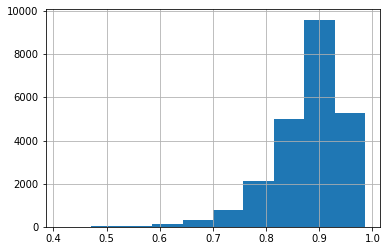

In [ ]:
hist = cosine_similarity_df['Cosine_similarity'].hist()

Now I sort by decreasing semantic change score:

In [ ]:
cosine_similarity_df_sorted = cosine_similarity_df.sort_values(by='Cosine_similarity', ascending=True)
cosine_similarity_df_sorted.head()

,Word,Cosine_similarity,Frequency_t1,Frequency_t2
5352,stud,0.413877,23,14
4021,1879,0.467864,36,23
2635,Utricularia,0.468761,68,43
5501,Caspary,0.471753,22,14
3717,Sara,0.474424,41,26


I add the total frequency:

In [ ]:
cosine_similarity_df_sorted["Total_Frequency"] = cosine_similarity_df_sorted["Frequency_t1"]+cosine_similarity_df_sorted["Frequency_t2"]
cosine_similarity_df_sorted

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency
5352,stud,0.413877,23,14,37
4021,1879,0.467864,36,23,59
2635,Utricularia,0.468761,68,43,111
5501,Caspary,0.471753,22,14,36
3717,Sara,0.474424,41,26,67
...,...,...,...,...,...
21188,Familie,0.982051,2,2,4
11439,mit,0.982179,7,4,11
16029,vom,0.983580,4,2,6
17034,avec,0.985625,3,2,5


I add a column with the category (function word, foreign word, numeral, and proper noun).

List of function words (from https://www.eltconcourse.com/training/initial/lexis/function_words.html)

In [ ]:
function_words = ['after', 'although', 'and', 'as', 'because', 'before', 'both', 'but', 'either', 'for', 'however', 'if','neither','nor','once','or','since','so','than','that','therefore','though','thus','till','unless','until','when','whenever','where','wherever','whether','while','yet	a','all','another','any','both','each','either','every','her','his','its','my','neither','no','other','our','per','some','that','the','their','these','this','those','whatever','whichever','your	about','above','across','after','against','ahead','along','among','amongst','around','as','at','bar','before','behind','below','beneath','beside','besides','between','beyond','but','by','down','during','except','for','from','in','inside','into','less','like	near','of','off','on','onto','opposite','outside','over','past','per','round','save','since','through','till','to','toward','under','underneath','until','up','upon','with','within','without	all','another','any','anybody','anyone','anything','both','each','either','everybody','everyone','everything','few','he','I','it','many','mine','neither','nobody','none','nothing','one','other','several','she','some','somebody','someone','something','that','these','they	this','those','we','what','whatever','which','whichever','who','whoever','whom','whose','you']

Applying the detect package doesn't work on individual words so I use the NLTK's English dictionary instead:

In [ ]:
#semantic_change.df.sorted['Language'] = semantic_change.df.sorted['Word'].apply(detect) 
import nltk
nltk.download('words')
english_vocab = set(w.lower() for w in nltk.corpus.words.words())
len(english_vocab)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


234377

In [ ]:
# create a list of our conditions
conditions = [
    (cosine_similarity_df_sorted['Word'].isin(function_words)), # function words
    ((cosine_similarity_df_sorted.Word.str.isdigit()) | (cosine_similarity_df_sorted['Word'].str.match('^\d*?1st$')) | (cosine_similarity_df_sorted['Word'].str.match('^\d*?2nd$')) | (cosine_similarity_df_sorted['Word'].str.match('^\d*?3rd$')) | (cosine_similarity_df_sorted['Word'].str.match('^\d*[^123]th$'))), # numbers
    (cosine_similarity_df_sorted['Word'].apply(lambda x: x[0].isupper() and x[1:len(x)].islower())), # proper nouns
    (np.invert(cosine_similarity_df_sorted['Word'].str.lower().isin(english_vocab))) # foreign words
    ]

# create a list of the values we want to assign for each condition
values = ['Function word','Numeral', 'Proper noun', 'Foreign word']

# create a new column and use np.select to assign values to it using our lists as arguments
cosine_similarity_df_sorted['Category_automatic'] = np.select(conditions, values, default = "")
cosine_similarity_df_sorted

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
5352,stud,0.413877,23,14,37,
4021,1879,0.467864,36,23,59,Numeral
2635,Utricularia,0.468761,68,43,111,Proper noun
5501,Caspary,0.471753,22,14,36,Proper noun
3717,Sara,0.474424,41,26,67,Proper noun
...,...,...,...,...,...,...
21188,Familie,0.982051,2,2,4,Proper noun
11439,mit,0.982179,7,4,11,Foreign word
16029,vom,0.983580,4,2,6,Foreign word
17034,avec,0.985625,3,2,5,Foreign word


I save this to a file:

In [ ]:
output_folder = '/content/drive/MyDrive/2021/Darwin paper/Files/Semantic_change_output/'
if not os.path.exists(output_folder):
  os.makedirs(output_folder)
cosine_similarity_df_sorted.to_csv(os.path.join(output_folder, 'Cosine_similarity_all_words.csv'), encoding='utf-8')

The top most changed words:

In [ ]:
cosine_similarity_df_sorted.head(100)

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
5352,stud,0.413877,23,14,37,
4021,1879,0.467864,36,23,59,Numeral
2635,Utricularia,0.468761,68,43,111,Proper noun
5501,Caspary,0.471753,22,14,36,Proper noun
3717,Sara,0.474424,41,26,67,Proper noun
...,...,...,...,...,...,...
2366,Upper,0.589116,78,50,128,Proper noun
6237,Buckley,0.589188,18,11,29,Proper noun
5749,Mormodes,0.590913,20,13,33,Proper noun
2857,Bird,0.591440,60,38,98,Proper noun


In [ ]:
cosine_similarity_df_sorted[cosine_similarity_df_sorted['Word'] =="scientist"]

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
6456,scientist,0.884423,17,11,28,


I plot the terms by their total frequency and semantic change score:

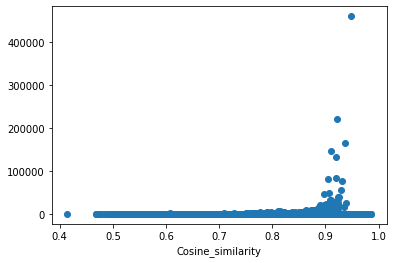

In [ ]:
ax = cosine_similarity_df_sorted.set_index('Cosine_similarity')['Total_Frequency'].plot(style='o')

Which words are the outliers? Function words and *Darwin*:

In [ ]:
cosine_similarity_df_sorted.loc[cosine_similarity_df_sorted['Total_Frequency'] > 10000].Word.tolist()

['would',
 'Darwin',
 'by',
 'or',
 'and',
 'from',
 'more',
 'at',
 'an',
 'may',
 'one',
 'see',
 'in',
 'think',
 '  ',
 'about',
 'on',
 'with',
 'of',
 'do',
 'any',
 'some',
 'send',
 'much',
 'if',
 'can',
 'this',
 'to',
 'but',
 'have',
 'will',
 'the',
 'for',
 'as',
 'which',
 'so',
 'not',
 'that',
 'a',
 'all',
 'be',
 'very',
 '-PRON-']

I exclude the outliers:

In [ ]:
cosine_similarity_df_sorted_nooutliers = cosine_similarity_df_sorted.loc[cosine_similarity_df_sorted['Total_Frequency'] < 10000]
cosine_similarity_df_sorted_nooutliers.shape

(23280, 6)

Plot:

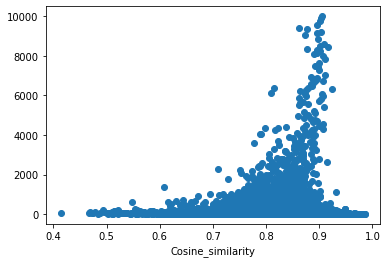

In [ ]:
ax = cosine_similarity_df_sorted_nooutliers.set_index('Cosine_similarity')['Total_Frequency'].plot(style='o')

What is the semantic change of the words we have chosen?

In [ ]:
words_chosen = ['protoplasm', 'curious', 'fertilisation', 'fertilise', 'analogy', 'analogous', 'homology', 'homologous', 'cleistogamic', 'physiology', 'physiological', 'ferment', 'science', 'scientist', 'scientific', 'evolution', 'evolutionary', 'evolve']

In [ ]:
cosine_similarity_df_sorted[cosine_similarity_df_sorted['Word'] == "scientist"]


,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
6456,scientist,0.884423,17,11,28,


In [ ]:
cosine_similarity_chosen = cosine_similarity_df_sorted[cosine_similarity_df_sorted['Word'].isin(words_chosen)]
cosine_similarity_chosen.to_csv(os.path.join(output_folder, 'cosine_similarity_chosen_words.csv'), encoding='utf-8')
cosine_similarity_chosen

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
2636,protoplasm,0.638491,68,43,111,
5403,ferment,0.801100,22,14,36,
943,fertilisation,0.808386,275,170,445,Foreign word
941,fertilise,0.818965,277,170,447,Foreign word
2325,physiology,0.831795,81,52,133,
1984,physiological,0.837908,101,65,166,
421,scientific,0.839232,656,430,1086,
4118,homology,0.842890,35,22,57,
1179,analogous,0.853460,211,133,344,
226,curious,0.864781,1283,840,2123,


In [ ]:
min(cosine_similarity_chosen.Cosine_similarity)

0.6384905576705933

In [ ]:
min(cosine_similarity_chosen.Total_Frequency)

28

In [ ]:
min(cosine_similarity_df_sorted.Cosine_similarity)

0.4138766825199127

Now I focus on those words that have a frequency higher than min(semantic_change_chosen.Total_Frequency). How many are there?

In [ ]:
cosine_similarity_df_sorted_filtered = cosine_similarity_df_sorted_nooutliers.loc[(cosine_similarity_df_sorted_nooutliers['Total_Frequency'] >= min(cosine_similarity_chosen.Total_Frequency))]
cosine_similarity_df_sorted_filtered.shape

(6480, 6)

Which words are these words?

In [ ]:
cosine_similarity_df_sorted_filtered

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
5352,stud,0.413877,23,14,37,
4021,1879,0.467864,36,23,59,Numeral
2635,Utricularia,0.468761,68,43,111,Proper noun
5501,Caspary,0.471753,22,14,36,Proper noun
3717,Sara,0.474424,41,26,67,Proper noun
...,...,...,...,...,...,...
4779,My,0.956321,28,17,45,Proper noun
5564,F.L.S.,0.956396,21,14,35,Foreign word
5011,servt,0.956619,26,16,42,Foreign word
5454,Truly,0.965719,22,14,36,Proper noun


Neighbours of *fertilisation* in the two time periods:

In [ ]:
print(model1.wv.similar_by_word("fertilisation", 10))
print(model2.wv.similar_by_word("fertilisation", 10))
cosine_similarity_df_sorted_filtered[cosine_similarity_df_sorted_filtered['Word'] == "fertilisation"]

[('fertilization', 0.8758518695831299), ('contrivance', 0.8129968643188477), ('impregnation', 0.8084515333175659), ('Passiflora', 0.8014850616455078), ('agency', 0.7770189046859741), ('orchid', 0.7742666602134705), ('impotence', 0.7644632458686829), ('self', 0.7620887756347656), ('orchis', 0.7603682279586792), ('Catasetum', 0.7582208514213562)]
[('fertilization', 0.9029185175895691), ('carnivorous', 0.7927517294883728), ('Alpine', 0.7897111177444458), ('Self', 0.7889798879623413), ('fertilize', 0.7871734499931335), ('alpine', 0.786170482635498), ('cross-', 0.7830774188041687), ('fertilise', 0.7808493971824646), ('contrivance', 0.7806875109672546), ('Lepidoptera', 0.7777403593063354)]


,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
943,fertilisation,0.808386,275,170,445,Foreign word


_Fertilization_ was initially heavily associated with flowers and beans in Darwin’s correspondence since its first mention in 1854. The context of usage seems to change in the letters over time. This is exemplified by varying neighbours such as Bees, orchids, and contrivance. After 1870, we noticed that the neighbours reflect his interest in plant behaviour, perhaps relating to his work leading up to the publication of "Cross and Self Fertilisation" in 1876 and "The Power of Movement in Plants" in 1880. 

I create a list for these words:

In [ ]:
highfreq_words = cosine_similarity_df_sorted_filtered.Word.tolist()
highfreq_words[:10]

['stud',
 '1879',
 'Utricularia',
 'Caspary',
 'Sara',
 'Tropics',
 'Pheasant',
 'Mivart',
 'cleavage',
 'Self']

Now I annotate the plot with these:

In [ ]:
cosine_similarity_df_sorted_filtered_p = cosine_similarity_df_sorted_filtered[['Word','Cosine_similarity', 'Total_Frequency']]
fig, ax = plt.subplots()
cosine_similarity_df_sorted_filtered_p.plot('Cosine_similarity', 'Total_Frequency', kind='scatter', ax=ax)
for k, v in cosine_similarity_df_sorted_filtered_p.iterrows():
  word = v['Word']
  sc = v['Cosine_similarity']
  f = v['Total_Frequency']
  #print("w", v['Word'])
  #print("sc:", str(sc))
  #print("f:", str(f))
  ax.annotate(word, xy=(sc,f))

What are the neighbours of these words in the two spaces?

In [ ]:
count = 0
for word in highfreq_words:
  count += 1
  if count < 10:
    print(word)
    print("Neighbours in first space:")
    print(model1.wv.similar_by_word(word, 10))
    print("Neighbours in second space:")
    print(model2.wv.similar_by_word(word, 10))

I print this to an output file:

In [ ]:
outfile = open(os.path.join(output_folder, 'Neighbours_freq_words.csv'), 'w+')

# Write header row:
outfile.write("Word, followed by  neighbours in first space and neighbours in second space\n") 
for word in highfreq_words:
  #print(word)
  #print("Neighbours in first space:")
  #print(model1.wv.similar_by_word(word, 10))
  #print("Neighbours in second space:")
  #print(model2.wv.similar_by_word(word, 10))
  for (w,c) in model1.wv.similar_by_word(word, 10):
    outfile.write(word+"\t" + w+"\t"+str(c))
  outfile.write("\n")
  for (w,c) in model2.wv.similar_by_word(word, 10):
    outfile.write(word+"\t"+w+"\t"+str(c))
  outfile.write("\n")
  
outfile.close()

## Semantic change detection using neighbours

We're going to implement the method proposed by Gonen, H., Jawahar, G., Seddah, D., & Goldberg, Y. (2020). Simple, Interpretable and Stable Method for Detecting Words with Usage Change across Corpora. In Proceedings of the 58th Annual Meeting of the Association for Computational Linguistics (pp. 538–555). https://doi.org/10.18653/v1/2020.acl-main.51 

Print the histogram of the frequency of the words in the corpus:

                Freq
count  73233.000000 
mean   59.930646    
std    2254.361411  
min    1.000000     
25%    1.000000     
50%    2.000000     
75%    5.000000     
max    459111.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efc8a42b390>]],
      dtype=object)

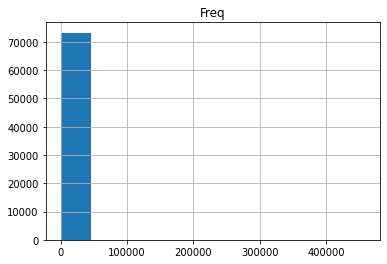

In [ ]:
model = sg_w5_f1
vocab = model.wv.index_to_key
frequencies = list()
for w in vocab:
  frequencies.append(model.wv.get_vecattr(w, "count"))
print(pd.DataFrame({'Word':vocab,'Freq':frequencies}).describe())
pd.DataFrame({'Word':vocab,'Freq':frequencies}).hist()

I exclude all words with frequency lower than min_freq and higher than max_freq:

In [ ]:
def filter_words(model, min_freq, max_freq):
  vocab = model.wv.index_to_key
  vocab_filtered = []
  for w in vocab:
    if model.wv.get_vecattr(w, "count") <max_freq and model.wv.get_vecattr(w, "count")>min_freq:
      vocab_filtered.append(w)
  return vocab_filtered

vocab1_filtered = filter_words(model1,2,50000)
vocab2_filtered = filter_words(model2,2,50000)
vocab_filtered = list(set(vocab1_filtered) & set(vocab2_filtered))

How many words?

In [ ]:
print(str(len(vocab_filtered)))

15877


Distribution of filtered word frequencies:

               Freq
count  22531.000000
mean   141.854689  
std    1438.893306 
min    4.000000    
25%    6.000000    
50%    11.000000   
75%    34.000000   
max    83971.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efc77944b90>]],
      dtype=object)

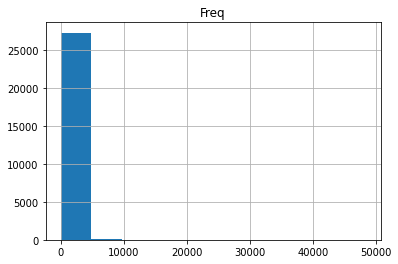

In [ ]:
word2freq = pd.DataFrame({'Word':vocab,'Freq':frequencies})
print(word2freq[(word2freq.Freq<100000) & (word2freq.Freq>3)].describe())
word2freq[(word2freq.Freq<50000) & (word2freq.Freq>2)].hist()

I extract the top_n neighbours and save them in a dictionary mapping a word to the list of its 100 neighbours:

In [ ]:
def extract_neighbours(w2vmodel, vocab_list, top_n):
  count = 0
  word2neighbours = dict()
  for w in vocab_list:
    count += 1
    #if (count % 100) == 0:
    #  print(str(count), "out of", str(len(vocab_list)), w)
    neighbours = w2vmodel.wv.similar_by_word(w, top_n)
    #print(str(neighbours))
    neighbour_list = list()
    for n in neighbours:
      neighbour_list.append(n[0])
    word2neighbours[w] = neighbour_list
  return word2neighbours

I apply this to model1 and model2 for filtered words:

In [ ]:
#word2neighbours1 = extract_neighbours(model1, model1.wv.index_to_key)
word2neighbours1 = extract_neighbours(model1, vocab1_filtered, 100)
#word2neighbours2 = extract_neighbours(model2, model2.wv.index_to_key)
word2neighbours2 = extract_neighbours(model2, vocab2_filtered, 100)

100 out of 20607 ever
200 out of 20607 several
300 out of 20607 nearly
400 out of 20607 genera
500 out of 20607 stand
600 out of 20607 towards
700 out of 20607 easily
800 out of 20607 heart
900 out of 20607 material
1000 out of 20607 daresay
1100 out of 20607 unfortunately
1200 out of 20607 Edit
1300 out of 20607 sleep
1400 out of 20607 specific
1500 out of 20607 plenty
1600 out of 20607 acquaintance
1700 out of 20607 wear
1800 out of 20607 freely
1900 out of 20607 blind
2000 out of 20607 strata
2100 out of 20607 subscription
2200 out of 20607 excessively
2300 out of 20607 eight
2400 out of 20607 majority
2500 out of 20607 Anne
2600 out of 20607 Sciences
2700 out of 20607 establishment
2800 out of 20607 transfer
2900 out of 20607 proposition
3000 out of 20607 thread
3100 out of 20607 breast
3200 out of 20607 impregnate
3300 out of 20607 peach
3400 out of 20607 estate
3500 out of 20607 omission
3600 out of 20607 eyelid
3700 out of 20607 gum
3800 out of 20607 encouragement
3900 out of 20

For every word in the intersection between the two vocabularies, compare its neighbours in t1 and its neighbours in t2; the semantic change score is the number of shared neighbours between the two divided by 100.
NB This is different from the formula in Gonen et al. (2020), who take the negative of the overlap.

In [ ]:
#vocab_12 = list(set(model1.wv.index_to_key) & set(model2.wv.index_to_key))
w2sc = dict()
for w in vocab_filtered:
  sc = len(list(set(word2neighbours1[w]) & set(word2neighbours2[w])))/100
  w2sc[w] = sc

I have saved these scores in the w2sc dictionary. Now I sort it by decreasing score to see which words changed the most:

In [ ]:
w2sc_sorted = sorted(w2sc.items(), key=lambda kv: kv[1], reverse=False)
w2sc_sorted[:10]

[('2ndly', 0.0),
 ('Ohio', 0.0),
 ('dissolution', 0.0),
 ('tailless', 0.0),
 ('debateable', 0.0),
 ('FD', 0.0),
 ('opake', 0.0),
 ('Hampstead', 0.0),
 ('prohibit', 0.0),
 ('Saporta', 0.0)]

What are the most changed words?

In [ ]:
top_changed = [i[0] for i in w2sc_sorted][:20]
top_changed

['2ndly',
 'Ohio',
 'dissolution',
 'tailless',
 'debateable',
 'FD',
 'opake',
 'Hampstead',
 'prohibit',
 'Saporta',
 'Afghanistan',
 'Chloride',
 'breaking',
 'grower',
 'Camels',
 'aqueous',
 'painting',
 'Desterro',
 'Divinity',
 'Monotremata']

What are their neighbours?

In [ ]:
for w in top_changed:
  print(w)
  print(str(word2neighbours1[w]))
  print(str(word2neighbours2[w]))

2ndly
['rigorously', 'compensation', 'Jollofs', 'showing', 'fecundity', 'intercross', 'disproportion', 'armature', 'mating', 'crucial', 'nutation', 'mammæ', 'albinism', 'criterion', 'initially', 'obliteration', 'caprice', 'elongation', 'interbreeding', 'silently', 'degeneration', 'axillary', 'offspre', 'centripetal', 'naturalisation', 'intermarry', 'susceptible', 'comprehensible', 'circumnutation', 'supposed', 'intensify', 'enlargement', 'inferiority', 'paralell', 'tenacity', 'abnormality', 'grouping', 'inappreciable', 'acorn', 'lepidoptera', 'acting', 'producer', 'proportionate', 'marrow', 'compactness', 'sufficiency', 'severest', 'fatten', 'basic', 'locomotive', 'substitution', 'heterogeneous', 'ramification', 'Hermaphrodites', 'extinguish', 'scottish', 'correlated', 'coloring', 'spatial', 'interstice', 'assumed', 'grasshopper', 'supersede', 'geometrical', 'adaptive', 'concealment', 'economic', 'smallness', 'counteract', 'magnitude', 'practicable', 'hooked', 'defensive', 'generalize'

In [ ]:
neighbours_df = pd.DataFrame(([w, w2sc[w], model1.wv.get_vecattr(w, "count") , model2.wv.get_vecattr(w, "count") ] for w in vocab_filtered), columns = ('Word', 'Neighbour_score', "Frequency_t1", "Frequency_t2"))
neighbours_df.describe()

,Neighbour_score,Frequency_t1,Frequency_t2
count,15877.000000,15877.000000,15877.000000
mean,0.064380,119.614789,75.244505
std,0.089923,959.505965,620.545063
min,0.000000,4.000000,3.000000
25%,0.010000,6.000000,4.000000
50%,0.020000,12.000000,8.000000
75%,0.090000,37.000000,23.000000
max,0.670000,49107.000000,31456.000000


Visualise the distribution of the semantic change scores with a histogram:

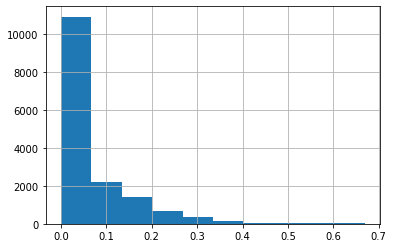

In [ ]:
hist = neighbours_df['Neighbour_score'].hist()

Now I sort by increasing neighbour score:

In [ ]:
neighbours_df_sorted = neighbours_df.sort_values(by='Neighbour_score', ascending=True)
neighbours_df_sorted.head(50)

,Word,Neighbour_score,Frequency_t1,Frequency_t2
12096,quoad,0.0,6,4
7091,leak,0.0,5,3
10971,Langer,0.0,4,3
7098,collaborator,0.0,8,5
7099,groom,0.0,7,5
10966,surprized,0.0,5,3
4422,Provence,0.0,7,5
4421,1803,0.0,4,3
7102,Sequoia,0.0,5,3
10958,carve,0.0,5,3


I add the total frequency:

In [ ]:
neighbours_df_sorted["Total_Frequency"] = neighbours_df_sorted["Frequency_t1"]+neighbours_df_sorted["Frequency_t2"]
neighbours_df_sorted

,Word,Neighbour_score,Frequency_t1,Frequency_t2,Total_Frequency
12096,quoad,0.00,6,4,10
7091,leak,0.00,5,3,8
10971,Langer,0.00,4,3,7
7098,collaborator,0.00,8,5,13
7099,groom,0.00,7,5,12
...,...,...,...,...,...
7720,5,0.63,786,492,1278
8669,December,0.63,137,86,223
12051,April,0.64,214,136,350
549,June,0.65,243,153,396


I add a column with the category (function word, foreign word, numeral, and proper noun).

In [ ]:
# create a list of our conditions
conditions = [
    (neighbours_df_sorted['Word'].isin(function_words)), # function words
    ((neighbours_df_sorted.Word.str.isdigit()) | (neighbours_df_sorted['Word'].str.match('^\d*?1st$')) | (neighbours_df_sorted['Word'].str.match('^\d*?2nd$')) | (neighbours_df_sorted['Word'].str.match('^\d*?3rd$')) | (neighbours_df_sorted['Word'].str.match('^\d*[^123]th$'))), # numbers
    (neighbours_df_sorted['Word'].apply(lambda x: x[0].isupper() and x[1:len(x)].islower())), # proper nouns
    (np.invert(neighbours_df_sorted['Word'].str.lower().isin(english_vocab))) # foreign words
    ]

# create a list of the values we want to assign for each condition
values = ['Function word','Numeral', 'Proper noun', 'Foreign word']

# create a new column and use np.select to assign values to it using our lists as arguments
neighbours_df_sorted['Category_automatic'] = np.select(conditions, values, default = "")
neighbours_df_sorted

,Word,Neighbour_score,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
12096,quoad,0.00,6,4,10,Foreign word
7091,leak,0.00,5,3,8,
10971,Langer,0.00,4,3,7,Proper noun
7098,collaborator,0.00,8,5,13,
7099,groom,0.00,7,5,12,
...,...,...,...,...,...,...
7720,5,0.63,786,492,1278,Numeral
8669,December,0.63,137,86,223,Proper noun
12051,April,0.64,214,136,350,Proper noun
549,June,0.65,243,153,396,Proper noun


I save this to a file:

In [ ]:
output_folder = '/content/drive/MyDrive/2021/Darwin paper/Files/Semantic_change_output/'
if not os.path.exists(output_folder):
  os.makedirs(output_folder)
neighbours_df_sorted.to_csv(os.path.join(output_folder, 'all_words_neighbourscore.csv'), encoding='utf-8')

## Comparison of the two methods for semantic change detection

In [ ]:
neighbours_df_sorted.sort_values(by='Word', ascending=True)

,Word,Neighbour_score,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
3520,,0.18,839,519,1358,Foreign word
7518,,0.41,28553,20542,49095,Foreign word
15365,,0.04,13,8,21,Foreign word
15392,,0.00,9,6,15,Foreign word
11324,,0.00,7,4,11,Foreign word
...,...,...,...,...,...,...
3626,☞,0.00,4,3,7,Foreign word
5262,♀,0.05,284,173,457,Foreign word
15467,♂,0.08,232,146,378,Foreign word
11229,〈,0.00,22,14,36,Foreign word


In [ ]:
cosine_similarity_df_sorted.sort_values(by='Word', ascending=True)

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
337,,0.608472,839,519,1358,Foreign word
9,,0.907147,28553,20542,49095,Foreign word
7694,,0.816608,13,8,21,Foreign word
9397,,0.743481,9,6,15,Foreign word
11189,,0.752918,7,4,11,Foreign word
...,...,...,...,...,...,...
17650,☿,0.930398,3,2,5,Foreign word
923,♀,0.657241,284,173,457,Foreign word
1085,♂,0.699295,232,146,378,Foreign word
5513,〈,0.627050,22,14,36,Foreign word


In [ ]:
semantic_change_2methods = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'inner')
semantic_change_2methods

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic,Neighbour_score
0,stud,0.413877,23,14,37,,0.00
1,1879,0.467864,36,23,59,Numeral,0.00
2,Utricularia,0.468761,68,43,111,Proper noun,0.00
3,Caspary,0.471753,22,14,36,Proper noun,0.00
4,Sara,0.474424,41,26,67,Proper noun,0.00
...,...,...,...,...,...,...,...
15872,516,0.981149,5,3,8,Numeral,0.09
15873,dawkin,0.981757,9,6,15,,0.24
15874,nach,0.981983,8,5,13,,0.37
15875,mit,0.982179,7,4,11,Foreign word,0.34


I integrate the neighbour score in the file:

In [ ]:
semantic_change_2methods_all = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'outer')
semantic_change_2methods_all.to_csv(os.path.join(output_folder, 'all_words_2scores.csv'), encoding='utf-8')
semantic_change_2methods_all

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic,Neighbour_score
0,stud,0.413877,23,14,37,,0.00
1,1879,0.467864,36,23,59,Numeral,0.00
2,Utricularia,0.468761,68,43,111,Proper noun,0.00
3,Caspary,0.471753,22,14,36,Proper noun,0.00
4,Sara,0.474424,41,26,67,Proper noun,0.00
...,...,...,...,...,...,...,...
23318,Familie,0.982051,2,2,4,Proper noun,NaN
23319,mit,0.982179,7,4,11,Foreign word,0.34
23320,vom,0.983580,4,2,6,Foreign word,NaN
23321,avec,0.985625,3,2,5,Foreign word,NaN


In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'] =="scientist"]

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic,Neighbour_score
10055,scientist,0.884423,17,11,28,,0.07


I plot the terms by two semantic change scores:

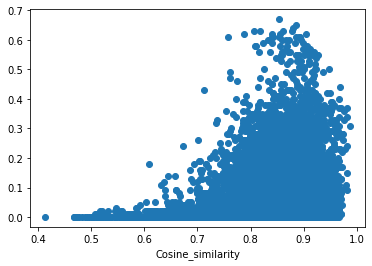

In [ ]:
ax = semantic_change_2methods.set_index('Cosine_similarity')['Neighbour_score'].plot(style='o')

In [ ]:
semantic_change_2methods_all.corr(method="spearman")

,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Neighbour_score
Cosine_similarity,1.000000,-0.642626,-0.639241,-0.642509,0.086991
Frequency_t1,-0.642626,1.000000,0.988534,0.999005,0.669929
Frequency_t2,-0.639241,0.988534,1.000000,0.993780,0.669938
Total_Frequency,-0.642509,0.999005,0.993780,1.000000,0.669454
Neighbour_score,0.086991,0.669929,0.669938,0.669454,1.000000


There seems to be a positive correlation: the higher the cosine similarity the higher the neighbour similarity.



In [ ]:
semantic_change_2methods_all.describe()

,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Neighbour_score
count,23323.000000,23323.000000,23323.000000,23323.000000,15877.000000
mean,0.878470,113.853664,71.983321,185.836985,0.064380
std,0.066656,2445.143893,1548.956199,3992.675708,0.089923
min,0.413877,2.000000,1.000000,3.000000,0.000000
25%,0.847949,3.000000,2.000000,5.000000,0.010000
50%,0.894638,7.000000,4.000000,11.000000,0.020000
75%,0.926540,20.000000,13.000000,33.000000,0.090000
max,0.986384,284506.000000,174605.000000,459111.000000,0.670000


Scores for chosen words:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].describe()

,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Neighbour_score
count,16.000000,16.000000,16.000000,16.000000,16.000000
mean,0.841837,249.937500,160.750000,410.687500,0.156250
std,0.063446,344.647157,225.478602,570.107793,0.110144
min,0.638491,17.000000,11.000000,28.000000,0.010000
25%,0.828587,33.000000,20.750000,53.750000,0.065000
50%,0.848175,102.500000,65.500000,168.000000,0.145000
75%,0.877057,275.500000,170.000000,445.500000,0.220000
max,0.920679,1283.000000,840.000000,2123.000000,0.370000


Scores for not chosen words:

In [ ]:
semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].describe()

,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Neighbour_score
count,23307.000000,23307.000000,23307.000000,23307.000000,15861.000000
mean,0.878495,113.760244,71.922384,185.682628,0.064287
std,0.066652,2445.964839,1549.475495,3994.015460,0.089858
min,0.413877,2.000000,1.000000,3.000000,0.000000
25%,0.847980,3.000000,2.000000,5.000000,0.010000
50%,0.894681,7.000000,4.000000,11.000000,0.020000
75%,0.926564,20.000000,13.000000,33.000000,0.090000
max,0.986384,284506.000000,174605.000000,459111.000000,0.670000


Compare the two means:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0,4]]

0.8418374210596085

I define a list of words that I expect did not change:

In [ ]:
not_changed = ['the', 'it', 'for', 'a', 'at', 'in', 'be', 'of', 'on', 'over', 'under']

Then I look at their scores:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)]

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic,Neighbour_score
3219,under,0.810521,1602,1013,2615,Function word,0.10
7586,over,0.864803,2174,1361,3535,Function word,0.16
12799,at,0.901483,14449,8417,22866,Function word,0.07
13366,in,0.904911,49107,31456,80563,Function word,0.04
14199,on,0.909373,19810,12670,32480,Function word,0.16
14254,of,0.909740,87876,59302,147178,Function word,NaN
16570,the,0.921887,129459,90613,220072,Function word,NaN
16746,for,0.922878,23843,15529,39372,Function word,0.12
18361,a,0.930757,46715,29808,76523,,0.06
19488,be,0.936264,102383,62432,164815,,NaN


In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)].describe()

,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Neighbour_score
count,10.000000,10.000000,10.000000,10.000000,7.000000
mean,0.901262,47741.800000,31260.100000,79001.900000,0.101429
std,0.037568,44649.359554,30196.870693,74786.726945,0.047759
min,0.810521,1602.000000,1013.000000,2615.000000,0.040000
25%,0.902340,15789.250000,9480.250000,25269.500000,0.065000
50%,0.909556,35279.000000,22668.500000,57947.500000,0.100000
75%,0.922630,78183.750000,52340.500000,130524.250000,0.140000
max,0.936264,129459.000000,90613.000000,220072.000000,0.160000


In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].describe()

,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Neighbour_score
count,16.000000,16.000000,16.000000,16.000000,16.000000
mean,0.841837,249.937500,160.750000,410.687500,0.156250
std,0.063446,344.647157,225.478602,570.107793,0.110144
min,0.638491,17.000000,11.000000,28.000000,0.010000
25%,0.828587,33.000000,20.750000,53.750000,0.065000
50%,0.848175,102.500000,65.500000,168.000000,0.145000
75%,0.877057,275.500000,170.000000,445.500000,0.220000
max,0.920679,1283.000000,840.000000,2123.000000,0.370000


Let's look at species:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word']=='species']

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic,Neighbour_score
3753,species,0.820366,311,190,501,,0.13


In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word']=='descent']

,Word,Cosine_similarity,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic,Neighbour_score
3059,descent,0.807972,176,110,286,,0.08


I compare the means:

In [ ]:
semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[0,4]]

Cosine_similarity    0.901262
Neighbour_score      0.101429
dtype: float64

### Systematic comparison of cosine similarity and neighbour similarity by different values of parameters

This is the list of non-scientific words currently analysed in the article:

In [ ]:
nonsci_analysed = ['lunch', 'presentation', 'herewith', 'heartfelt', 'presentation', 'inconvenient']

This is the list of scientific words currently analysed in the article:

In [ ]:
sci_analysed = ['molecule', 'fundamental', 'spiritual', 'latent', 'wriggle', 'sediment']

I define a function that, given a minimum frequency, a maximum frequency and the number of top neighbours, does the following: filter the vocabularies, apply this to model1 and model2 for filtered words, calculates the neghbour similarity score, define a dataframe with this score, save to a file, combine the dataframe with the cosine similarity score, I plot the terms by two semantic change scores, calculate Spearman correlation between the two scores, compares the means of the two scores for the chosen words (gold standard), the words that did not change, the words that were not in the gold standard, the non-scientific words currently analysed in the article and the scientific words currently analysed in the article.

In [ ]:
def compare_two_methods(min_freq, max_freq, top_n):
  vocab1_filtered = filter_words(model1,min_freq, max_freq)
  vocab2_filtered = filter_words(model2,min_freq, max_freq)
  #print("Vocabulary 1 filtered: "+str(len(vocab1_filtered)))
  #print("Vocabulary 2 filtered: "+str(len(vocab2_filtered)))
  vocab_filtered = list(set(vocab1_filtered) & set(vocab2_filtered))
  #print("1")
  word2neighbours1 = extract_neighbours(model1, vocab1_filtered, top_n)
  #print("2")
  word2neighbours2 = extract_neighbours(model2, vocab2_filtered, top_n)
  #print("3")
  w2sc = dict()
  for w in vocab_filtered:
    sc = len(list(set(word2neighbours1[w]) & set(word2neighbours2[w])))/100
    w2sc[w] = sc
  #print("4")
  w2sc_sorted = sorted(w2sc.items(), key=lambda kv: kv[1], reverse=False)
  neighbours_df = pd.DataFrame(([w, w2sc[w], model1.wv.get_vecattr(w, "count") , model2.wv.get_vecattr(w, "count") ] for w in vocab_filtered), columns = ('Word', 'Neighbour_score', "Frequency_t1", "Frequency_t2"))
  #print("5")
  #print("6")
  neighbours_df_sorted = neighbours_df.sort_values(by='Neighbour_score', ascending=True)
  #print("7")
  neighbours_df_sorted["Total_Frequency"] = neighbours_df_sorted["Frequency_t1"]+neighbours_df_sorted["Frequency_t2"]
  #print("8")
  conditions = [
    (neighbours_df_sorted['Word'].isin(function_words)), # function words
    ((neighbours_df_sorted.Word.str.isdigit()) | (neighbours_df_sorted['Word'].str.match('^\d*?1st$')) | (neighbours_df_sorted['Word'].str.match('^\d*?2nd$')) | (neighbours_df_sorted['Word'].str.match('^\d*?3rd$')) | (neighbours_df_sorted['Word'].str.match('^\d*[^123]th$'))), # numbers
    (neighbours_df_sorted['Word'].apply(lambda x: x[0].isupper() and x[1:len(x)].islower())), # proper nouns
    (np.invert(neighbours_df_sorted['Word'].str.lower().isin(english_vocab))) # foreign words
    ]
  # create a list of the values we want to assign for each condition
  values = ['Function word','Numeral', 'Proper noun', 'Foreign word']
  neighbours_df_sorted['Category_automatic'] = np.select(conditions, values, default = "")
  #print("9")
  neighbours_df_sorted.to_csv(os.path.join(output_folder, 'all_words_neighbourscore'+str(min_freq)+'-'+str(max_freq)+'-'+str(top_n)+'.csv'), encoding='utf-8')
  #print("10")
  semantic_change_2methods = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'inner')
  #print("11")
  semantic_change_2methods_all = cosine_similarity_df_sorted.merge(neighbours_df_sorted, how = 'outer')
  #print("12")
  semantic_change_2methods_all.to_csv(os.path.join(output_folder, 'all_words_2scores'+str(min_freq)+'-'+str(max_freq)+'-'+str(top_n)+'.csv'), encoding='utf-8')
  #print("13")
  ax = semantic_change_2methods.set_index('Cosine_similarity')['Neighbour_score'].plot(style='o')
  #print("14")
  corr = (semantic_change_2methods_all.corr(method="spearman")).Neighbour_score[0]
  #print("Correlation:",corr)
  #print("Means of chosen words:")
  mean_cos_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0]][0]
  mean_nei_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[4]][0]
  median_cos_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[0]][0]
  median_nei_chosen = semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0,4]])
  #print("Means of all other words:")
  mean_cos_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0]][0]
  mean_nei_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[4]][0]
  median_cos_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[0]][0]
  median_nei_other = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].median()[[4]][0]
  #print(semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(words_chosen)].mean()[[0,4]])
  #print("Means of not changed words:")
  mean_cos_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[0]][0]
  mean_nei_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[4]][0]
  median_cos_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].median()[[0]][0]
  median_nei_unchanged = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(not_changed)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(not_changed)].mean()[[0,4]])
  #print("Means of non-scientific words currently analysed in the article:")
  mean_cos_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].mean()[[0]][0]
  mean_nei_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].mean()[[4]][0]
  median_cos_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].median()[[0]][0]
  median_nei_nonscian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(nonsci_analysed)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(nonsci_analysed)].mean()[[0,4]])
  #print("Means of scientific words currently analysed in the article:")
  mean_cos_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].mean()[[0]][0]
  mean_nei_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].mean()[[4]][0]
  median_cos_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].median()[[0]][0]
  median_nei_scian = semantic_change_2methods_all[~semantic_change_2methods_all['Word'].isin(sci_analysed)].median()[[4]][0]
  #print(semantic_change_2methods_all[semantic_change_2methods_all['Word'].isin(sci_analysed)].mean()[[0,4]])
  return [vocab1_filtered, vocab2_filtered, vocab_filtered, corr, 
          mean_cos_chosen, mean_nei_chosen, mean_cos_other, mean_nei_other, mean_cos_unchanged, mean_nei_unchanged, mean_cos_nonscian, mean_nei_nonscian, mean_cos_scian, mean_nei_scian, 
          median_cos_chosen, median_nei_chosen, median_cos_other, median_nei_other, median_cos_unchanged, median_nei_unchanged, median_cos_nonscian, median_nei_nonscian, median_cos_scian,median_nei_scian]

I try different parameters:

0 10000 10
0 10000 50
0 10000 100
0 10000 1000
0 100000 10
0 100000 50
0 100000 100
0 100000 1000
0 200000 10
0 200000 50
0 200000 100
0 200000 1000
1 10000 10
1 10000 50
1 10000 100
1 10000 1000
1 100000 10
1 100000 50
1 100000 100
1 100000 1000
1 200000 10
1 200000 50
1 200000 100
1 200000 1000
5 10000 10
5 10000 50
5 10000 100
5 10000 1000
5 100000 10
5 100000 50
5 100000 100
5 100000 1000
5 200000 10
5 200000 50
5 200000 100
5 200000 1000
10 10000 10
10 10000 50
10 10000 100
10 10000 1000
10 100000 10
10 100000 50
10 100000 100
10 100000 1000
10 200000 10
10 200000 50
10 200000 100
10 200000 1000
50 10000 10
50 10000 50
50 10000 100
50 10000 1000
50 100000 10
50 100000 50
50 100000 100
50 100000 1000
50 200000 10
50 200000 50
50 200000 100
50 200000 1000


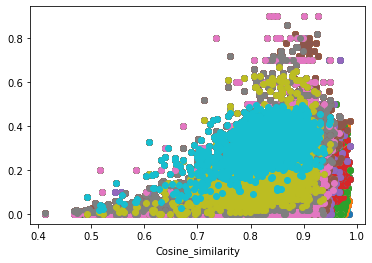

In [ ]:
summary = open(os.path.join(output_folder, 'summary_results.csv'), 'w+')
writer = csv.writer(summary, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
writer.writerow(['min_freq','max_freq', 'top_n', 'vocab1_filtered', 'vocab2_filtered', 
                 'Spearman correlation cosine_sim-neighbour_sim', 
                 'mean_neighbourscore_chosen_words','mean_cosinescore_chosen_words',
                 'mean_neighbourscore_other_words','mean_cosinescore_other_words',
                 'mean_neighbourscore_unchanged_words','mean_cosinescore_unchanged_words',
                 'mean_neighbourscore_non_sci_words_analysed','mean_cosinescore_non_sci_words_analysed',
                 'mean_neighbourscore_sci_words_analysed','mean_cosinescore_sci_words_analysed',
                 'median_neighbourscore_chosen_words','median_cosinescore_chosen_words',
                 'median_neighbourscore_other_words','median_cosinescore_other_words',
                 'median_neighbourscore_unchanged_words','median_cosinescore_unchanged_words',
                 'median_neighbourscore_non_sci_words_analysed','median_cosinescore_non_sci_words_analysed',
                 'median_neighbourscore_sci_words_analysed','median_cosinescore_sci_words_analysed'])
min_freq_values = [0,1,5,10,50]
max_freq_values = [10000,100000,200000]
top_n_values = [10,50,100,1000]
for min_freq in min_freq_values:
  for max_freq in max_freq_values:
    for top_n in top_n_values:
      print(min_freq, max_freq, top_n)
      [vocab1_filtered, vocab2_filtered, vocab_filtered, corr, 
       mean_cos_chosen, mean_nei_chosen, mean_cos_other, mean_nei_other, mean_cos_unchanged, mean_nei_unchanged, mean_cos_nonscian, mean_nei_nonscian, mean_cos_scian, mean_nei_scian, 
       median_cos_chosen, median_nei_chosen, median_cos_other, median_nei_other, median_cos_unchanged, median_nei_unchanged, median_cos_nonscian, median_nei_nonscian, median_cos_scian, median_nei_scian] = compare_two_methods(min_freq, max_freq, top_n)
      writer.writerow([min_freq, max_freq, top_n, len(vocab1_filtered), len(vocab2_filtered), corr,
                 mean_cos_chosen,mean_nei_chosen,mean_cos_other,mean_nei_other,mean_cos_unchanged,mean_nei_unchanged, mean_cos_nonscian, mean_nei_nonscian,mean_cos_scian,mean_nei_scian,
                 median_cos_chosen,median_nei_chosen,median_cos_other,median_nei_other,median_cos_unchanged,median_nei_unchanged, median_cos_nonscian, median_nei_nonscian,median_cos_scian,median_nei_scian])
summary.close()